# Pipeline base com PyNILM:  avaliação de Taxa Amostral e Janelas na base REDD

In [120]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "17") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)

NILMTK -> Detalhes sobre o dataset REDD:


## Preparando Janelas utilizadas no Experimento

Consumo geral dos medidores/aparelhos no período:


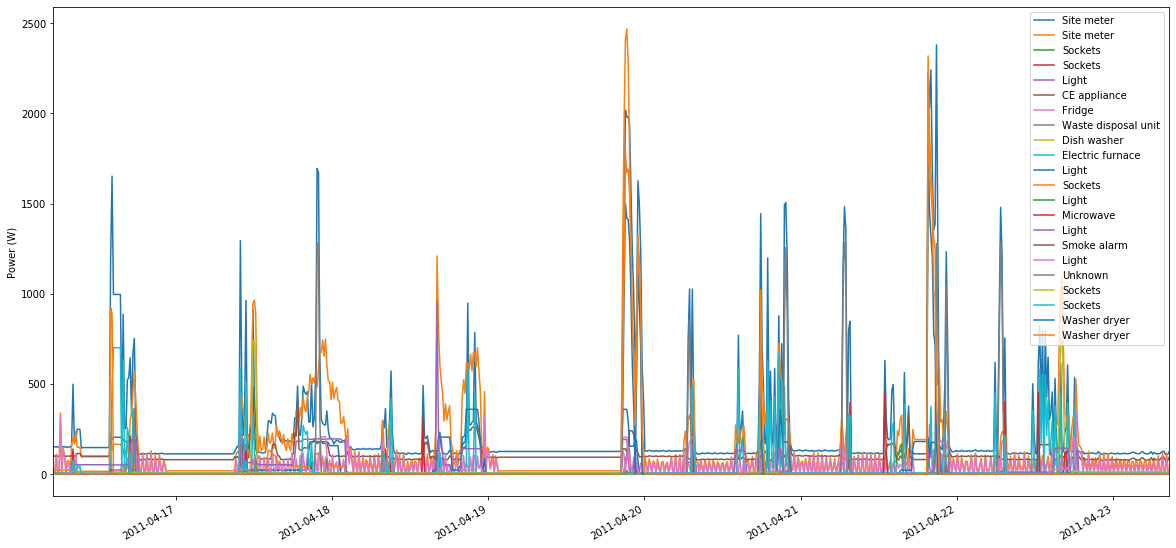

In [4]:
# Teste da classe
janelas = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16 05:11:30',
    fim_intervalo='2011-04-23 08:43:26',
    debug = False
)


# Plots
fig = plt.figure(figsize=(20, 10))
print("Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas.residencia.elec.meters)):
    janelas.residencia.elec.meters[m].plot();

In [5]:
# Extrair series divididas em janelas para cada medidor
# a cada 90 segundos, em uma taxa de 3s
dados_cargas = janelas.preparar(taxa_amostral=3, intervalo_medicao=90)

# Disposicao das janelas preparadas
pprint(dados_cargas)

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.

## Preparando Amostras (medidores residência ) e Rótulos (aparelhos)

In [6]:
# Listando as cargas que possuem janelas preparadas
janelas.lista_cargas(dados_cargas)

[(1, 'site_meter'),
 (2, 'site_meter'),
 (3, 'sockets'),
 (4, 'sockets'),
 (5, 'light'),
 (6, 'ce_appliance'),
 (7, 'fridge'),
 (8, 'waste_disposal_unit'),
 (9, 'dish_washer'),
 (10, 'electric_furnace'),
 (11, 'light'),
 (12, 'sockets'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (15, 'light'),
 (16, 'microwave'),
 (17, 'light'),
 (18, 'smoke_alarm'),
 (19, 'light'),
 (20, 'unknown')]

In [7]:
# Filtrando dados para conjunto de cargas
# NOTA: Os lares norte-americanos têm suprimentos de energia em fase dividida. 
#   Cada divisão é de 120 volts em relação ao neutro. As duas divisões 
#   totalizam 240 volts, por isso os dois 'site_meter'. 
#
#   Além disso, aparelhos que demandam energia (secadora, por exemplo) podem se 
#   conectar a ambas as divisões; na REDD se mede separadamente as duas divisões 
#   para esses tais aparelhos, contemplando no NILMTK dois medidores por 
#   dispositivo de 240 volts.

# Apenas duas fases da corrente eletrica da residencia
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
print("Dados das janelas de ambos medidores da residência:")
print("---")
pprint(dados_medidores)

print("\n\n")

# Apenas dados de aparelhos da residencia
dados_aparelhos = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (3, 'sockets'),
        (4, 'sockets'),
        (5, 'light'),
        (6, 'ce_appliance'),
        (7, 'fridge'),
        (8, 'waste_disposal_unit'),
        (9, 'dish_washer'),
        (10, 'electric_furnace'),
        (11, 'light'),
        (12, 'sockets'),
        (13, 'washer_dryer'),
        (14, 'washer_dryer'),
        (15, 'light'),
        (16, 'microwave'),
        (17, 'light'),
        (18, 'smoke_alarm'),
        (19, 'light'),
        (20, 'unknown')
    ]
)
print("Dados das janelas dos aparelhos da residência:")
print("---")
pprint(dados_aparelhos)

Dados das janelas de ambos medidores da residência:
---
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.05612, 153.01077, 152.7641 , ..., 107.80511, 116.91384,
       122.40183], dtype=float32),
              'total': array([4411.6836, 4590.323 , 4582.923 , ..., 3234.1533, 3507.4153,
       3672.055 ], dtype

              'media': array([1.        , 1.        , 1.        , ..., 0.96666664, 0.96666664,
       1.        ], dtype=float32),
              'total': array([30., 30., 30., ..., 29., 29., 30.], dtype=float32)}},
 {'carga': 'unknown',
  'instancia': 20,
  'janelas': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'rotulos': {'estado': array([0, 0, 0, ..., 0, 0, 0]),
              'media': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
              'total': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}]


In [8]:

# Janelas do medidores agregados
X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# Normalizando dados
# X = MinMaxScaler().fit_transform(X.T).T

print("* Dados dos medidores (Amostras / X):")
print("   - Shape:", X.shape)
print("   - Media:", np.mean(X))
print("   - Desvio:", np.std(X))

# Y = irá depender da carga a ser classificada

* Dados dos medidores (Amostras / X):
   - Shape: (6861, 30)
   - Media: 413.0859
   - Desvio: 673.9321


In [9]:
# Verificar apenas janelas válidaso: com medicao total MAIOR QUE ZERO 
# (ou seja, amostras que possuam ao menos uma carga ativa - janelas zeradas
# são INÚTEIS para aprendizado do modelo, além de contribuir para desbalanceamento)
idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
print("* Janelas com TODOS aparelhos desligados: {} (~{:.1f}% das amostras)".format(
    X.shape[0] - len(idx_janelas_validas), 
    ( 1 - (len(idx_janelas_validas)/X.shape[0]) )*100 
))
print()

# AMOSTRAS -> Filtrando apenas JANELAS validas
X = X[idx_janelas_validas]
print("* Amostras validadas (X shape):", X.shape)
print()

# APARELHOS -> Filtrando apenas JANELAS validas
print("* Rotulos (estado) validados:")
for i in range(len(dados_aparelhos)):
    
    dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
    
    rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
    
    dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
    print("   - `{}-{}`: {} -> {}".format(
        dados_aparelhos[i]["carga"].upper(), dados_aparelhos[i]["instancia"],
        Counter(rotulos["estado"]), 
        Counter(dados_aparelhos[i]["rotulos"]["estado"])
    ))

* Janelas com TODOS aparelhos desligados: 0 (~0.0% das amostras)

* Amostras validadas (X shape): (6861, 30)

* Rotulos (estado) validados:
   - `SOCKETS-3`: Counter({0: 4497, 1: 2364}) -> Counter({0: 4497, 1: 2364})
   - `SOCKETS-4`: Counter({0: 5858, 1: 1003}) -> Counter({0: 5858, 1: 1003})
   - `LIGHT-5`: Counter({0: 6092, 1: 769}) -> Counter({0: 6092, 1: 769})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({1: 5844, 0: 1017}) -> Counter({1: 5844, 0: 1017})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6138, 1: 723}) -> Counter({0: 6138, 1: 723})
   - `DISH_WASHER-9`: Counter({1: 6339, 0: 522}) -> Counter({1: 6339, 0: 522})
   - `ELECTRIC_FURNACE-10`: Counter({1: 6833, 0: 28}) -> Counter({1: 6833, 0: 28})
   - `LIGHT-11`: Counter({0: 5056, 1: 1805}) -> Counter({0: 5056, 1: 1805})
   - `SOCKETS-12`: Counter({0: 4866, 1: 1995}) -> Counter({0: 4866, 1: 1995})
   - `WASHER_DRYER-13`: Counter({0: 6613, 1: 248}) -> Counter({0: 6613, 1: 248})
   - `WAS

In [10]:
# TOP-5 aparelhos com maior consumo
top_aparelhos_consumo = []
for m in janelas.residencia.elec.submeters().select_top_k(5).meters:
    instancia = m.instance()
    carga = m.label().lower().replace(" ","_")
    if type(instancia)==tuple and len(instancia) > 1:
        for i in instancia:
            top_aparelhos_consumo.append((i, carga))
    else:
        top_aparelhos_consumo.append((instancia, carga))
        
print("\n")
print("------------------------------------------------------------------")
print("* Top-5 aparelhos com maior consumo total de energia no intervalo:")
print("------------------------------------------------------------------")
pprint(top_aparelhos_consumo)
print("----------------------------------------------")

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

------------------------------------------------------------------
* Top-5 aparelhos com maior consumo total de energia no intervalo:
------------------------------------------------------------------
[(6, 'ce_appliance'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (7, 'fridge'),
 (10, 'electric_furnace'),
 (17, 'light')]
----------------------------------------------


**Distribuções dos estados (rótulos classificação):**

   - `CE_APPLIANCE-6`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5264}
   - `FRIDGE-7`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5125, 0: 139}
   - `ELECTRIC_FURNACE-10`: {1: 5236, 0: 28}
   - `WASHER_DRYER-13`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 5018, 1: 246}
   - `WASHER_DRYER-14`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 4945, 1: 319}
   - `LIGHT-17`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 3134, 1: 2130})
   
   
<u>**CONCLUSÕES PARCIAIS:**</u>
1. É possível perceber que o aparelho `CE_APPLIANCE-6` é inviável de treinar nestas configurações, pois há apenas amostras positivas;
2. `LIGHT-17` é o aparelho com melhor equlibrio de amostras, ou seja, possui menor grau de desbalanceamento;
3. De resto, todos os aparelhos possuem grande desbalanceamento; `talvez seja necessário avaliar individualmente o tamanho da janela considerada para cada aparelho`.
    * Corrobora [Fagiani *et. al* (2019)](https://www.mdpi.com/1996-1073/12/7/1371), os quais afirmam que *"(...) geralmente, apesar da tarefa a ser resolvida dependendo da formulação do algoritmo, a precisão da desagregação diminui proporcionalmente com a variação da taxa de amostragem."*

Portanto, vamos considerar avaliar diferentes 'sample rate' em um pipeline de classificação (RP+CNN) comum neste estudo, considerando as cargas de maior consumo.

In [11]:
# Eletrônicos, Luzes, refrigerador, lava loucas, aquecedor, secadora de
# roupas, alarmes de incêndio, equipamentos de banheiro, utensílios de
# cozinha, Micro-ondas, utensílios externos.

In [12]:
# # TOP-5 aparelhos com maior DEMANDA de energia
# df_energia = janelas.residencia.elec.dataframe_of_meters()

# fig = plt.figure(figsize=(20,8))
# cargas = janelas.residencia.elec.get_labels(df_energia.columns)[2:]
# legenda = []
# dados_energia = [] # Lista com estatisticas por caga
# for i, coluna in enumerate(df_energia.columns[2:]):
#     instancia = ""
#     if hasattr(coluna, "instance"):
#         instancia = coluna.instance
#     else:
#         instancia = tuple([m.instance for m in coluna.meters])

#     serie = np.nan_to_num(df_energia[coluna].values)
#     dados_energia.append({
#         "carga": cargas[i],
#         "instancia": instancia,
#         "total": np.sum(serie),
#         "maximo": np.max(serie),
#         "minimo": np.min(serie),
#         "media": np.mean(serie),
#         "desvio": np.std(serie)
#     })
#     legenda.append(f"{cargas[i]}-{str(instancia)}")
#     plt.plot(np.arange(df_energia.shape[0]), serie)
# plt.legend(legenda);
# plt.title("Consumo por Dispositivo dentro do Intervalo")
# plt.show();

# sorted(dados_energia, key=lambda k: k['maximo'], reverse=False) 

## Transformar Séries (Janelas) em Imagens

In [397]:

# fig, axes = plt.subplots(1,4, figsize=(20,5))

# axes[0].plot(np.arange(len(X[3])), X[3])
# axes[0].set_title("Série Original (Janela)")
# # axes[0].grid(False)

# # RPs
# X_rp = RecurrencePlot().fit_transform(X)
# axes[1].imshow(X_rp[3], cmap="plasma");
# axes[1].set_title("RP")
# axes[1].grid(False)

# # GASF
# X_gasf = GramianAngularField(method="summation").fit_transform(X)
# axes[2].imshow(X_gasf[3], cmap="plasma");
# axes[2].set_title("GASF")
# axes[2].grid(False)

# # GASF
# X_gadf = GramianAngularField(method="difference").fit_transform(X)
# axes[3].imshow(X_gadf[3], cmap="plasma");
# axes[3].set_title("GADF")
# axes[3].grid(False)

# # # MTF
# # X_mtf = MarkovTransitionField().fit_transform(X[np.where(np.sum(X, axis=1)>0)[0]])
# # plt.imshow(X_mtf[3], cmap="plasma");
# # plt.title("MTF")
# # plt.grid(False)
# # plt.show()
# plt.show()

# # Gerando imagens RGB N canais
# X_imagem = np.stack([X_rp, X_gasf, X_gadf], axis=-1)
# print("* Shape da matriz de amostras:", X_imagem.shape)

# Modelagem

In [4]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
def convnet(
    input_shape_ = (30, 30, 1), 
    output_dim=6, 
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'softmax'
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation=output_activation))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


In [5]:
# NOTA IMPORTANTE: Este notebook já foi executado, e os resultados persistidos
#  no arquivo `17-resultados_taxa-amostragem_janelas`.
#  O notebook ORIGINAL (com os outputs desta célula) foi corrompido, devido
#  ao tamanho resultante (>70MB).

if not os.path.isfile(os.path.join(caminho_dados_notebook, 'resultados_taxa-amostragem_janelas.csv')):
    # Cenarios de avaliacao:
    # ---
    resultados = {
        "carga": [],
        "taxa_amostragem": [],
        "janela": [],
        "loss": [],
        "acuracia": []
    }

    # Intervalo de tempo e residencia considerados na base REDD
    janelas = Janelas(
        base=redd,
        id_residencia=3,
        inicio_intervalo='2011-04-16 05:11:30',
        fim_intervalo='2011-04-23 08:43:26',
        debug = False
    )

    # Testar diferentes taxas de amostragem
    taxas_amostragem = [1, 2, 3, 5, 8]
    for taxa in taxas_amostragem:
        for janela in [30, 60, 90, 180, 360, 540, 720]:#, 900, 1080]: # nao foi possivel devido ao limite modelo/GPU

            print()
            print("-="*10, f"AMOSTRAGEM `{taxa}s` / JANELA `{janela}`", "=-"*10)
            print()

            # Extrair series divididas em janelas para cada medidor
            print("* Preparando dados das janelas para a taxa de amostragem...")
            dados_cargas = janelas.preparar(
                taxa_amostral = taxa, 
                intervalo_medicao= janela 
            )
            print()

            # Apenas duas fases da corrente eletrica da residencia
            print("* Dividindo cargas entre medidores (mains) e aparelhos...")
            dados_medidores = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (1, 'site_meter'),
                    (2, 'site_meter'),    
                ]
            )
            # Apenas dados de aparelhos da residencia
            dados_aparelhos = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (3, 'sockets'),
                    (4, 'sockets'),
                    (5, 'light'),
                    (6, 'ce_appliance'),
                    (7, 'fridge'),
                    (8, 'waste_disposal_unit'),
                    (9, 'dish_washer'),
                    (10, 'electric_furnace'),
                    (11, 'light'),
                    (12, 'sockets'),
                    (13, 'washer_dryer'),
                    (14, 'washer_dryer'),
                    (15, 'light'),
                    (16, 'microwave'),
                    (17, 'light'),
                    (18, 'smoke_alarm'),
                    (19, 'light'),
                    (20, 'unknown')
                ]
            )

            # <<< Limpando memoria >>>
            dados_cargas = None
            del dados_cargas
            gc.collect()
            # <<< Limpando memoria >>>

            print()

            # Gerar matriz de amostras do modelo (X) e preparar rotulos Y (estado das cargas)
            print("* Preparando amostras e rótulos...")

            # Validar tamanho dos dados de medidores (podem ter mais registros que os aparelhos)
            janela_media_medidores = int(np.sum([len(d["janelas"])for d in dados_medidores])/len(dados_medidores))
            janela_media_aparelhos = int(np.sum([len(d["janelas"])for d in dados_aparelhos])/len(dados_aparelhos))

            # Ajustando para medidores terem o mesmo shape de janelas dos aparelhos 
            if janela_media_medidores > janela_media_aparelhos:
                diferenca = janela_media_medidores-janela_media_aparelhos
                print("  -> Diferenca encontrada entre medidores/aparelhos:", diferenca, ", ajustando..")
                for i in range(len(dados_medidores)):
                    removidos = 0
                    while removidos < diferenca:
                        # Remover ultima janela
                        dados_medidores[i]["janelas"] = dados_medidores[i]["janelas"][:-1,:]
                        removidos += 1


            X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

            # <<< Limpando memoria >>>
            dados_medidores = None
            del dados_medidores
            gc.collect()
            # <<< Limpando memoria >>>

            # Normalizacao dos dados (DESUSO)
            #X = MinMaxScaler().fit_transform(X.T).T # Normalizando dados

            # Selecionando apenas janelas VALIDAS (ocorrencia de ao menos 1 carga)
            # TODO: Implementar na biblioteca esta rotina de validacao
            idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
            X = X[idx_janelas_validas]
            for i in range(len(dados_aparelhos)):
                dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
                rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
                dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
                print("   - `{}-{}`: {} -> {}".format(
                    dados_aparelhos[i]["carga"].upper(), dados_aparelhos[i]["instancia"],
                    Counter(rotulos["estado"]), 
                    Counter(dados_aparelhos[i]["rotulos"]["estado"])
                ))
            print()

            print("* Transformando séries (amostras) em imagens...")
            # Transformacao das series em RPs...
            X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)


            # <<< Limpando memoria >>>
            X = None
            del X
            gc.collect()
            # <<< Limpando memoria >>>

            # Projetando RPs em canais...
            X_imagem = np.stack([X_rp], axis=-1).astype(np.float16) # 1 canal

            # <<< Limpando memoria >>>
            X_rp = None
            del X_rp
            gc.collect()
            # <<< Limpando memoria >>>

            print("  -> Shape da matriz de amostras:", X_imagem.shape)
            print()

            # Loop sobre TODOS os aparelhos (binarios, parametros similares estudo ja feito)
            print("* Avaliando modelos binários para cada um dos aparelhos, aguarde...")
            print()
            for aparelho in dados_aparelhos:
                caminho_persistencia_resultados = os.path.join(
                    caminho_imagens_notebook, 
                    'taxa-{}_janela-{}_{}'.format(
                        taxa, janela, f'{aparelho["carga"]}-{aparelho["instancia"]}' 
                    )
                )
                if not os.path.isdir(caminho_persistencia_resultados):
                    try:
                        print("-"*50)
                        print()

                        y = aparelho["rotulos"]["estado"]

                        print(f"_ Dados do aparelho `{aparelho['carga'].upper()} - {aparelho['instancia']}` (Y / rótulo:)")
                        print("   - ", Counter(y))
                        print()

                        # Split de treino / teste
                        print("_ Treinando o modelo classificador de estados...")

                        estratificacao = y
                        # Ver se é inviavel estratificacao
                        for v in Counter(y).values():
                            if v == 1:
                                estratificacao = None
                                break
                        X_treino, X_teste, y_treino, y_teste = train_test_split(
                            X_imagem, y,
                            test_size=FRACAO_TESTE,
                            stratify=estratificacao,
                            random_state=SEED
                        )

                        # Treinando modelo
                        modelo = convnet(
                            input_shape_= X_imagem[0,:,:].shape,
                            output_dim = 1,
                            loss_function='binary_crossentropy',
                            metrics=['accuracy'],
                            output_activation='sigmoid'
                        )

                        historico = modelo.fit(
                            X_treino, y_treino,
                            validation_data=(X_teste, y_teste),
                            epochs=EPOCAS,
                            batch_size=TAMANHO_LOTE,
                            verbose=VERBOSIDADE
                        )

                        print()

                        # Resultados do modelo
                        r = modelo.evaluate(X_teste, y_teste)
                              
                        # Incluindo dados no dataframe
                        resultados["carga"].append(f'{aparelho["carga"]} - {aparelho["instancia"]}')
                        resultados["taxa_amostragem"].append(taxa)
                        resultados["janela"].append(janela)
                        resultados["loss"].append(r[0])
                        resultados["acuracia"].append(r[1])
                                                   
                        # Persistindo o log individual do modelo (backup)
                        if not os.path.isdir(os.path.join(caminho_persistencia_resultados)):
                            os.makedirs(caminho_persistencia_resultados)
                        with open(os.path.join(caminho_persistencia_resultados, "resultados.log"), "w") as log:
                            log.write(
                                "{},{},{},{},{}".format(
                                    f'{aparelho["carga"]} - {aparelho["instancia"]}',
                                    taxa,
                                    janela,
                                    r[0],
                                    r[1]
                                )
                            )

                        # TODO: implementar opção de apenas salvar imagens na pasta
                        #   do notebook ao inves de exibi-las no IPython notebook
                        #   padrao -> os.path.join(CAMINHO_IMAGENS_NOTEBOOK, 'taxa-{}.janela-{}_convergencia-loss.png'.format(taxa, janela))
                        # ---                 
                        # Avaliando modelo
                        relatorio_classificacao_aparelho(
                            modelo, X_teste, y_teste, 
                            f'{aparelho["carga"]} - {aparelho["instancia"]}',
                            caminho_persistencia=caminho_persistencia_resultados
                        )
                        print()

                    except Exception as e:
                        print(f" !# Não foi possível treinar o modelo para a combinação de taxa `{str(taxa)}` / janela `{str(janela)}`: {str(e)}")
                else:
                    print(f" !# Modelo já treinado para a combinação de carga `{aparelho['carga']}-{aparelho['instancia']}` / taxa `{str(taxa)}` / janela `{str(janela)}`")
                    print()
                          
                    # Lendo resultados dos logs
                    with open(os.path.join(caminho_persistencia_resultados, "resultados.log"), "r") as log:
                        dados = log.readlines()[0].split(',')
                        resultados["carga"].append(dados[0])
                        resultados["taxa_amostragem"].append(int(dados[1]))
                        resultados["janela"].append(int(dados[2]))
                        resultados["loss"].append(float(dados[3]))
                        resultados["acuracia"].append(round(float(dados[4]),7))

            # <<< Limpando memoria >>>
            X_imagem = None
            del X_imagem
            dados_aparelhos = None
            del dados_aparelhos
            gc.collect()
            # <<< Limpando memoria >>>

            print()

    # Exportar resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"))
                              
else:
    print("####################################")
    print(f"#          A T E N Ç Ã O           #")
    print("####################################")
    print("\nExecução já realizada anteriormente.")
    print(f"\nOs resultados estão disponíveis no arquivo \n`{os.path.join(caminho_dados_notebook,'resultados_taxa-amostragem_janelas.csv')}`")
    print("\n####################################")


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 14117, 1: 6466}) -> Counter({0: 14117, 1: 6466})
   - `SOCKETS-4`: Counter({0: 18272, 1: 2311}) -> Counter({0: 18272, 1: 2311})
   - `LIGHT-5`: Counter({0: 18847, 1: 1736}) -> Counter({0: 18847, 1: 1736})
   - `CE_APPLIANCE-6`: Counter({1: 20583}) -> Counter({1: 20583})
   - `FRIDGE-7`: Counter({1: 16491, 0: 4092}) -> Counter({1: 16491, 0: 4092})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 18933, 1: 1650}) -> Counter({0: 18933, 1: 1650})
   - `DISH_WASHER-9`: Counter({1: 18839, 0: 1744}) -> Counter({1: 18839, 0: 1744})
   - `ELECTRIC_FURNACE-10`: Counter({1: 20491, 0: 92}) -> Counter({1: 20491, 0: 92

 !# Modelo já treinado para a combinação de carga `sockets-4` / taxa `1` / janela `360`

 !# Modelo já treinado para a combinação de carga `light-5` / taxa `1` / janela `360`

 !# Modelo já treinado para a combinação de carga `ce_appliance-6` / taxa `1` / janela `360`

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1495, 0: 220})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.90 - ETA: 0s - loss: 0.2765 - accuracy: 0.87 - ETA: 0s - loss: 0.4700 - accuracy: 0.89 - ETA: 0s - loss: 0.4107 - accuracy: 0.88 - ETA: 0s - loss: 0.3699 - accuracy: 0.88 - ETA: 0s - loss: 0.3367 - accuracy: 0.87 - ETA: 0s - loss: 0.3162 - accuracy: 0.87 - 1s 1ms/sample - loss: 0.3153 - accuracy: 0.8811
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,88.11
Precisão,99.69
Recall,86.63
F1-score,92.70
F1-macro,80.31
Hamming Loss,0.12
AUC,0.92
Suporte (y=0),55.00
Suporte (y=1),374.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1416, 1: 299})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.1554 - accuracy: 0.84 - ETA: 0s - loss: 2.1772 - accuracy: 0.84 - ETA: 0s - loss: 1.6065 - accuracy: 0.86 - ETA: 0s - loss: 1.8893 - accuracy: 0.83 - ETA: 0s - loss: 2.0308 - accuracy: 0.84 - ETA: 0s - loss: 2.2531 - accuracy: 0.84 - ETA: 0s - loss: 2.2743 - accuracy: 0.84 - 1s 1ms/sample - loss: 2.2930 - accuracy: 0.8415
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,84.15
Precisão,56.60
Recall,40.00
F1-score,46.88
F1-macro,68.78
Hamming Loss,0.16
AUC,0.67
Suporte (y=0),354.00
Suporte (y=1),75.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 1612, 0: 103})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 14.6551 - accuracy: 0.843 - ETA: 0s - loss: 5.3043 - accuracy: 0.895 - ETA: 0s - loss: 3.5483 - accuracy: 0.90 - ETA: 0s - loss: 2.5911 - accuracy: 0.91 - ETA: 0s - loss: 2.1651 - accuracy: 0.92 - ETA: 0s - loss: 1.8131 - accuracy: 0.92 - ETA: 0s - loss: 1.6625 - accuracy: 0.91 - 1s 1ms/sample - loss: 1.6133 - accuracy: 0.9207
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,92.07
Precisão,94.03
Recall,97.77
F1-score,95.86
F1-macro,50.71
Hamming Loss,0.08
AUC,0.51
Suporte (y=0),26.00
Suporte (y=1),403.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 1711, 0: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.96 - ETA: 0s - loss: 0.0372 - accuracy: 0.98 - ETA: 0s - loss: 1.8592 - accuracy: 0.98 - ETA: 0s - loss: 1.3317 - accuracy: 0.99 - ETA: 0s - loss: 1.0382 - accuracy: 0.99 - ETA: 0s - loss: 0.8519 - accuracy: 0.99 - ETA: 0s - loss: 0.7221 - accuracy: 0.99 - 1s 1ms/sample - loss: 0.7003 - accuracy: 0.9953
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.53
Precisão,99.77
Recall,99.77
F1-score,99.77
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),428.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1219, 1: 496})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.96 - ETA: 0s - loss: 0.8054 - accuracy: 0.85 - ETA: 0s - loss: 0.8057 - accuracy: 0.88 - ETA: 0s - loss: 1.2522 - accuracy: 0.87 - ETA: 0s - loss: 1.4723 - accuracy: 0.86 - ETA: 0s - loss: 2.2990 - accuracy: 0.84 - ETA: 0s - loss: 4.0691 - accuracy: 0.84 - 1s 1ms/sample - loss: 3.9527 - accuracy: 0.8438
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,84.38
Precisão,83.53
Recall,57.26
F1-score,67.94
F1-macro,78.81
Hamming Loss,0.16
AUC,0.76
Suporte (y=0),305.00
Suporte (y=1),124.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1163, 1: 552})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.8754 - accuracy: 0.62 - ETA: 0s - loss: 0.6681 - accuracy: 0.69 - ETA: 0s - loss: 0.7628 - accuracy: 0.68 - ETA: 0s - loss: 1.8214 - accuracy: 0.70 - ETA: 0s - loss: 1.7756 - accuracy: 0.70 - ETA: 0s - loss: 2.1577 - accuracy: 0.70 - ETA: 0s - loss: 2.3359 - accuracy: 0.69 - 1s 1ms/sample - loss: 2.3635 - accuracy: 0.6946
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,69.46
Precisão,59.46
Recall,15.94
F1-score,25.14
F1-macro,52.98
Hamming Loss,0.31
AUC,0.55
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1613, 1: 102})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 7.4579 - accuracy: 0.90 - ETA: 0s - loss: 2.6648 - accuracy: 0.95 - ETA: 0s - loss: 2.0916 - accuracy: 0.95 - ETA: 0s - loss: 4.5177 - accuracy: 0.93 - ETA: 0s - loss: 3.8870 - accuracy: 0.94 - ETA: 0s - loss: 5.3335 - accuracy: 0.93 - ETA: 0s - loss: 4.6666 - accuracy: 0.93 - 1s 1ms/sample - loss: 4.5536 - accuracy: 0.9371
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,93.71
Precisão,42.86
Recall,11.54
F1-score,18.18
F1-macro,57.45
Hamming Loss,0.06
AUC,0.55
Suporte (y=0),403.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1590, 1: 125})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 4.2791 - accuracy: 0.96 - ETA: 0s - loss: 1.6138 - accuracy: 0.96 - ETA: 0s - loss: 3.1003 - accuracy: 0.94 - ETA: 0s - loss: 4.9406 - accuracy: 0.94 - ETA: 0s - loss: 4.0233 - accuracy: 0.94 - ETA: 0s - loss: 3.4859 - accuracy: 0.92 - ETA: 0s - loss: 2.9548 - accuracy: 0.93 - 1s 1ms/sample - loss: 3.2592 - accuracy: 0.9324
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,93.24
Precisão,55.00
Recall,35.48
F1-score,43.14
F1-macro,69.77
Hamming Loss,0.07
AUC,0.67
Suporte (y=0),398.00
Suporte (y=1),31.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1305, 1: 410})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.6065 - accuracy: 0.71 - ETA: 0s - loss: 1.6046 - accuracy: 0.80 - ETA: 0s - loss: 1.1308 - accuracy: 0.83 - ETA: 0s - loss: 0.9858 - accuracy: 0.85 - ETA: 0s - loss: 0.8639 - accuracy: 0.84 - ETA: 0s - loss: 1.0718 - accuracy: 0.84 - ETA: 0s - loss: 1.2594 - accuracy: 0.84 - 1s 1ms/sample - loss: 1.2770 - accuracy: 0.8392
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,83.92
Precisão,74.29
Recall,50.49
F1-score,60.12
F1-macro,75.02
Hamming Loss,0.16
AUC,0.72
Suporte (y=0),326.00
Suporte (y=1),103.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 1696, 0: 19})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.96 - ETA: 0s - loss: 0.1296 - accuracy: 0.96 - ETA: 0s - loss: 0.1627 - accuracy: 0.96 - ETA: 0s - loss: 0.1596 - accuracy: 0.97 - ETA: 0s - loss: 0.1245 - accuracy: 0.97 - ETA: 0s - loss: 0.1105 - accuracy: 0.98 - ETA: 0s - loss: 0.0959 - accuracy: 0.98 - 1s 1ms/sample - loss: 0.0933 - accuracy: 0.9837
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.37
Precisão,98.83
Recall,99.53
F1-score,99.18
F1-macro,49.59
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),5.00
Suporte (y=1),424.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1085, 1: 630})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.8471 - accuracy: 0.75 - ETA: 0s - loss: 1.5391 - accuracy: 0.77 - ETA: 0s - loss: 1.6686 - accuracy: 0.79 - ETA: 0s - loss: 1.5541 - accuracy: 0.79 - ETA: 0s - loss: 1.3793 - accuracy: 0.80 - ETA: 0s - loss: 1.4272 - accuracy: 0.79 - ETA: 0s - loss: 1.8194 - accuracy: 0.79 - 1s 1ms/sample - loss: 1.7915 - accuracy: 0.7949
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,79.49
Precisão,79.17
Recall,60.13
F1-score,68.35
F1-macro,76.59
Hamming Loss,0.21
AUC,0.75
Suporte (y=0),271.00
Suporte (y=1),158.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 1654, 0: 61})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `360`:  OOM when allocating tensor with shape[32,32,358,358] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-d4056e5d6d1c>:206) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_207772]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 1711, 0: 4})

_ Treinando o modelo classificador

,Unknown - 20
Acurácia,86.01
Precisão,36.11
Recall,26.00
F1-score,30.23
F1-macro,61.23
Hamming Loss,0.14
AUC,0.60
Suporte (y=0),379.00
Suporte (y=1),50.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `1s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({1: 575, 0: 568}) -> Counter({1: 575, 0: 568})
   - `SOCKETS-4`: Counter({0: 842, 1: 301}) -> Counter({0: 842, 1: 301})
   - `LIGHT-5`: Counter({0: 867, 1: 276}) -> Counter({0: 867, 1: 276})
   - `CE_APPLIANCE-6`: Counter({1: 1143}) -> Counter({1: 1143})
   - `FRIDGE-7`: Counter({1: 1000, 0: 143}) -> Counter({1: 1000, 0: 143})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 894, 1: 249}) -> Counter({0: 894, 1: 249})
   - `DISH_WASHER-9`: Counter({1: 1084, 0: 59}) -> Counter({1: 1084, 0: 59})
   - `ELE

 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `720`: OOM when allocating tensor with shape[1013888,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_54/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 586, 1: 271})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` / janela `720`: OOM when allocating tensor with shape[1013888,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_55/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 563, 1: 294})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `1` 

   - `CE_APPLIANCE-6`: Counter({1: 3430}) -> Counter({1: 3430})
   - `FRIDGE-7`: Counter({1: 2959, 0: 471}) -> Counter({1: 2959, 0: 471})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 2978, 1: 452}) -> Counter({0: 2978, 1: 452})
   - `DISH_WASHER-9`: Counter({1: 3193, 0: 237}) -> Counter({1: 3193, 0: 237})
   - `ELECTRIC_FURNACE-10`: Counter({1: 3418, 0: 12}) -> Counter({1: 3418, 0: 12})
   - `LIGHT-11`: Counter({0: 2494, 1: 936}) -> Counter({0: 2494, 1: 936})
   - `SOCKETS-12`: Counter({0: 2385, 1: 1045}) -> Counter({0: 2385, 1: 1045})
   - `WASHER_DRYER-13`: Counter({0: 3275, 1: 155}) -> Counter({0: 3275, 1: 155})
   - `WASHER_DRYER-14`: Counter({0: 3237, 1: 193}) -> Counter({0: 3237, 1: 193})
   - `LIGHT-15`: Counter({0: 2700, 1: 730}) -> Counter({0: 2700, 1: 730})
   - `MICROWAVE-16`: Counter({1: 3386, 0: 44}) -> Counter({1: 3386, 0: 44})
   - `LIGHT-17`: Counter({0: 2196, 1: 1234}) -> Counter({0: 2196, 1: 1234})
   - `SMOKE_ALARM-18`: Counter({1: 3257, 0: 173}) -> Counter({1: 3257, 0:

,Sockets - 3
Acurácia,80.07
Precisão,85.95
Recall,72.22
F1-score,78.49
F1-macro,79.96
Hamming Loss,0.20
AUC,0.80
Suporte (y=0),142.00
Suporte (y=1),144.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 843, 1: 300})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`:  OOM when allocating tensor with shape[32,32,268,268] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-d4056e5d6d1c>:206) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_247562]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 867, 1: 276})

_ Treinando o modelo classificador de e


--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 1131, 0: 12})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`:  OOM when allocating tensor with shape[32,32,268,268] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_63/conv2d_126/Conv2D (defined at <ipython-input-5-d4056e5d6d1c>:206) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_261522]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 713, 1: 430})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / jane

 !# Modelo já treinado para a combinação de carga `light-17` / taxa `3` / janela `30`

 !# Modelo já treinado para a combinação de carga `smoke_alarm-18` / taxa `3` / janela `30`

 !# Modelo já treinado para a combinação de carga `light-19` / taxa `3` / janela `30`

 !# Modelo já treinado para a combinação de carga `unknown-20` / taxa `3` / janela `30`



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 6886, 1: 3405}) -> Counter({0: 6886, 1: 3405})
   - `SOCKETS-4`: Counter({0: 8935, 1: 1356}) -> Counter({0: 8935, 1: 1356})
   - `LIGHT-5`: Counter({0: 9256, 1: 1035}) -> Counter({0: 9256, 1: 1035})
   - `CE_APPLIANCE-6`: Counter({1: 10291}) -> Cou

* Transformando séries (amostras) em imagens...
  -> Shape da matriz de amostras: (1143, 180, 180, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({1: 575, 0: 568})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.93 - ETA: 0s - loss: 1.3196 - accuracy: 0.84 - 0s 425us/sample - loss: 6.6567 - accuracy: 0.8322
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,83.22
Precisão,85.29
Recall,80.56
F1-score,82.86
F1-macro,83.21
Hamming Loss,0.17
AUC,0.83
Suporte (y=0),142.00
Suporte (y=1),144.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 842, 1: 301})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`:  OOM when allocating tensor with shape[32,32,178,178] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-d4056e5d6d1c>:206) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_279601]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 867, 1: 276})

_ Treinando o modelo classificador de e

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 752, 0: 105})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: OOM when allocating tensor with shape[107648,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_156/kernel/Initializer/random_uniform/
--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 646, 1: 211})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: OOM when allocating tensor with shape[107648,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_157/kernel/Initializer/random_uniform/
--------------------------------------------------

_ Dados do ap

   - `SOCKETS-3`: Counter({0: 6880, 1: 3411}) -> Counter({0: 6880, 1: 3411})
   - `SOCKETS-4`: Counter({0: 8944, 1: 1347}) -> Counter({0: 8944, 1: 1347})
   - `LIGHT-5`: Counter({0: 9260, 1: 1031}) -> Counter({0: 9260, 1: 1031})
   - `CE_APPLIANCE-6`: Counter({1: 10291}) -> Counter({1: 10291})
   - `FRIDGE-7`: Counter({1: 9767, 0: 524}) -> Counter({1: 9767, 0: 524})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 9333, 1: 958}) -> Counter({0: 9333, 1: 958})
   - `DISH_WASHER-9`: Counter({1: 9464, 0: 827}) -> Counter({1: 9464, 0: 827})
   - `ELECTRIC_FURNACE-10`: Counter({1: 10247, 0: 44}) -> Counter({1: 10247, 0: 44})
   - `LIGHT-11`: Counter({0: 7626, 1: 2665}) -> Counter({0: 7626, 1: 2665})
   - `SOCKETS-12`: Counter({0: 7363, 1: 2928}) -> Counter({0: 7363, 1: 2928})
   - `WASHER_DRYER-13`: Counter({0: 9984, 1: 307}) -> Counter({0: 9984, 1: 307})
   - `WASHER_DRYER-14`: Counter({0: 9843, 1: 448}) -> Counter({0: 9843, 1: 448})
   - `LIGHT-15`: Counter({0: 8357, 1: 1934}) -> Counter({0: 8357

,Sockets - 3
Acurácia,71.94
Precisão,58.00
Recall,55.69
F1-score,56.82
F1-macro,68.02
Hamming Loss,0.28
AUC,0.68
Suporte (y=0),1720.00
Suporte (y=1),853.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 8944, 1: 1347})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.78 - ETA: 0s - loss: 0.2769 - accuracy: 0.86 - ETA: 0s - loss: 0.2660 - accuracy: 0.86 - ETA: 0s - loss: 0.2658 - accuracy: 0.86 - 0s 71us/sample - loss: 0.2669 - accuracy: 0.8694
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,86.94
Precisão,57.14
Recall,1.19
F1-score,2.33
F1-macro,47.66
Hamming Loss,0.13
AUC,0.51
Suporte (y=0),2236.00
Suporte (y=1),337.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 9260, 1: 1031})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.87 - ETA: 0s - loss: 0.2782 - accuracy: 0.89 - ETA: 0s - loss: 0.2669 - accuracy: 0.89 - ETA: 0s - loss: 0.2587 - accuracy: 0.89 - 0s 73us/sample - loss: 0.2573 - accuracy: 0.8990
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,89.90
Precisão,25.00
Recall,0.39
F1-score,0.76
F1-macro,47.72
Hamming Loss,0.10
AUC,0.50
Suporte (y=0),2315.00
Suporte (y=1),258.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 10291})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 2.7067e-17 - accuracy: 1.00 - ETA: 0s - loss: 4.9973e-17 - accuracy: 1.00 - ETA: 0s - loss: 4.9805e-17 - accuracy: 1.00 - ETA: 0s - loss: 5.0707e-17 - accuracy: 1.00 - 0s 67us/sample - loss: 5.0580e-17 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),2573.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 9767, 0: 524})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.96 - ETA: 0s - loss: 0.2129 - accuracy: 0.94 - ETA: 0s - loss: 0.2673 - accuracy: 0.94 - ETA: 0s - loss: 0.2335 - accuracy: 0.95 - 0s 79us/sample - loss: 0.2369 - accuracy: 0.9491
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,94.91
Precisão,94.91
Recall,100.00
F1-score,97.39
F1-macro,48.69
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),131.00
Suporte (y=1),2442.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 9333, 1: 958})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.87 - ETA: 0s - loss: 0.2190 - accuracy: 0.91 - ETA: 0s - loss: 0.2207 - accuracy: 0.91 - ETA: 0s - loss: 0.2149 - accuracy: 0.90 - 0s 77us/sample - loss: 0.2164 - accuracy: 0.9067
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,90.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.55
Hamming Loss,0.09
AUC,0.50
Suporte (y=0),2333.00
Suporte (y=1),240.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 9464, 0: 827})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 1.00 - ETA: 0s - loss: 0.2400 - accuracy: 0.92 - ETA: 0s - loss: 0.2383 - accuracy: 0.92 - ETA: 0s - loss: 0.2357 - accuracy: 0.92 - 0s 76us/sample - loss: 0.2428 - accuracy: 0.9195
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,91.95
Precisão,91.95
Recall,100.00
F1-score,95.81
F1-macro,47.90
Hamming Loss,0.08
AUC,0.50
Suporte (y=0),207.00
Suporte (y=1),2366.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 10247, 0: 44})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 0.0667 - accuracy: 0.99 - ETA: 0s - loss: 0.0592 - accuracy: 0.99 - ETA: 0s - loss: 0.0446 - accuracy: 0.99 - 0s 74us/sample - loss: 0.0479 - accuracy: 0.9949
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.49
Precisão,99.57
Recall,99.92
F1-score,99.75
F1-macro,49.87
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),11.00
Suporte (y=1),2562.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 7626, 1: 2665})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.81 - ETA: 0s - loss: 0.4263 - accuracy: 0.83 - ETA: 0s - loss: 0.4321 - accuracy: 0.81 - ETA: 0s - loss: 0.4188 - accuracy: 0.82 - 0s 77us/sample - loss: 0.4252 - accuracy: 0.8243
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,82.43
Precisão,66.07
Recall,66.07
F1-score,66.07
F1-macro,77.11
Hamming Loss,0.18
AUC,0.77
Suporte (y=0),1907.00
Suporte (y=1),666.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 7363, 1: 2928})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.81 - ETA: 0s - loss: 0.5461 - accuracy: 0.70 - ETA: 0s - loss: 0.5248 - accuracy: 0.73 - ETA: 0s - loss: 0.5050 - accuracy: 0.75 - 0s 72us/sample - loss: 0.5115 - accuracy: 0.7497
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,74.97
Precisão,55.85
Recall,57.38
F1-score,56.60
F1-macro,69.51
Hamming Loss,0.25
AUC,0.70
Suporte (y=0),1841.00
Suporte (y=1),732.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 9984, 1: 307})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.96 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - 0s 76us/sample - loss: 0.0747 - accuracy: 0.9778
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.78
Precisão,95.45
Recall,27.27
F1-score,42.42
F1-macro,70.65
Hamming Loss,0.02
AUC,0.64
Suporte (y=0),2496.00
Suporte (y=1),77.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 9843, 1: 448})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 1.00 - ETA: 0s - loss: 0.1227 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1135 - accuracy: 0.9670
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.70
Precisão,100.00
Recall,24.11
F1-score,38.85
F1-macro,68.58
Hamming Loss,0.03
AUC,0.62
Suporte (y=0),2461.00
Suporte (y=1),112.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 8357, 1: 1934})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.3631 - accuracy: 0.81 - ETA: 0s - loss: 0.3478 - accuracy: 0.82 - ETA: 0s - loss: 0.3623 - accuracy: 0.83 - 0s 77us/sample - loss: 0.3482 - accuracy: 0.8395
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,83.95
Precisão,59.17
Recall,47.31
F1-score,52.58
F1-macro,71.46
Hamming Loss,0.16
AUC,0.70
Suporte (y=0),2089.00
Suporte (y=1),484.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 10141, 0: 150})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.96 - ETA: 0s - loss: 0.0412 - accuracy: 0.99 - ETA: 0s - loss: 0.0594 - accuracy: 0.98 - ETA: 0s - loss: 0.0545 - accuracy: 0.98 - 0s 72us/sample - loss: 0.0714 - accuracy: 0.9852
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.52
Precisão,98.52
Recall,100.00
F1-score,99.26
F1-macro,49.63
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),38.00
Suporte (y=1),2535.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 6669, 1: 3622})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.71 - ETA: 0s - loss: 0.5215 - accuracy: 0.76 - ETA: 0s - loss: 0.5180 - accuracy: 0.76 - ETA: 0s - loss: 0.5065 - accuracy: 0.77 - 0s 78us/sample - loss: 0.5106 - accuracy: 0.7688
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,76.88
Precisão,73.38
Recall,53.86
F1-score,62.13
F1-macro,72.74
Hamming Loss,0.23
AUC,0.72
Suporte (y=0),1667.00
Suporte (y=1),906.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 9629, 0: 662})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.4929 - accuracy: 0.81 - ETA: 0s - loss: 0.2360 - accuracy: 0.92 - ETA: 0s - loss: 0.2184 - accuracy: 0.93 - ETA: 0s - loss: 0.2134 - accuracy: 0.93 - 0s 81us/sample - loss: 0.2197 - accuracy: 0.9355
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,93.55
Precisão,93.55
Recall,100.00
F1-score,96.67
F1-macro,48.33
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),166.00
Suporte (y=1),2407.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 10235, 0: 56})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.00 - ETA: 0s - loss: 0.0287 - accuracy: 0.99 - ETA: 0s - loss: 0.0275 - accuracy: 0.99 - ETA: 0s - loss: 0.0215 - accuracy: 0.99 - 0s 73us/sample - loss: 0.0286 - accuracy: 0.9946
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.46
Precisão,99.46
Recall,100.00
F1-score,99.73
F1-macro,49.86
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),14.00
Suporte (y=1),2559.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 9306, 1: 985})

_ Treinando o modelo classificador de estados...

2573/2573 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.87 - ETA: 0s - loss: 0.2751 - accuracy: 0.89 - ETA: 0s - loss: 0.2656 - accuracy: 0.89 - ETA: 0s - loss: 0.2590 - accuracy: 0.90 - 0s 76us/sample - loss: 0.2556 - accuracy: 0.9044
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,90.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.49
Hamming Loss,0.10
AUC,0.50
Suporte (y=0),2327.00
Suporte (y=1),246.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 4498, 1: 2363}) -> Counter({0: 4498, 1: 2363})
   - `SOCKETS-4`: Counter({0: 5861, 1: 1000}) -> Counter({0: 5861, 1: 1000})
   - `LIGHT-5`: Counter({0: 6093, 1: 768}) -> Counter({0: 6093, 1: 768})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({1: 6609, 0: 252}) -> Counter({1: 6609, 0: 252})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6143, 1: 718}) -> Counter({0: 6143, 1: 718})
   - `DISH_WASHER-9`: Counter({1: 6338, 0: 523}) -> Counter({1: 6338, 0: 52

,Sockets - 3
Acurácia,75.17
Precisão,61.90
Recall,72.59
F1-score,66.82
F1-macro,73.50
Hamming Loss,0.25
AUC,0.75
Suporte (y=0),1125.00
Suporte (y=1),591.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 5861, 1: 1000})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.87 - ETA: 0s - loss: 0.2369 - accuracy: 0.88 - ETA: 0s - loss: 0.2493 - accuracy: 0.88 - 0s 78us/sample - loss: 0.2506 - accuracy: 0.8840
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,88.40
Precisão,68.61
Recall,37.60
F1-score,48.58
F1-macro,71.02
Hamming Loss,0.12
AUC,0.67
Suporte (y=0),1466.00
Suporte (y=1),250.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6093, 1: 768})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.90 - ETA: 0s - loss: 0.2588 - accuracy: 0.89 - ETA: 0s - loss: 0.2619 - accuracy: 0.88 - 0s 81us/sample - loss: 0.2612 - accuracy: 0.8881
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,88.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.04
Hamming Loss,0.11
AUC,0.50
Suporte (y=0),1524.00
Suporte (y=1),192.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.1208e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.2074e-11 - accuracy: 1.00 - ETA: 0s - loss: 1.1226e-11 - accuracy: 1.00 - 0s 75us/sample - loss: 1.1422e-11 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 6609, 0: 252})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.93 - ETA: 0s - loss: 0.1649 - accuracy: 0.95 - ETA: 0s - loss: 0.1574 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1522 - accuracy: 0.9633
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,96.33
Precisão,96.33
Recall,100.00
F1-score,98.13
F1-macro,49.07
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),63.00
Suporte (y=1),1653.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6143, 1: 718})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.84 - ETA: 0s - loss: 0.2363 - accuracy: 0.88 - ETA: 0s - loss: 0.2235 - accuracy: 0.89 - 0s 68us/sample - loss: 0.2245 - accuracy: 0.8939
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,89.39
Precisão,40.00
Recall,2.22
F1-score,4.21
F1-macro,49.30
Hamming Loss,0.11
AUC,0.51
Suporte (y=0),1536.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 6338, 0: 523})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.87 - ETA: 0s - loss: 0.2435 - accuracy: 0.91 - ETA: 0s - loss: 0.2433 - accuracy: 0.92 - 0s 67us/sample - loss: 0.2405 - accuracy: 0.9237
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,92.37
Precisão,92.37
Recall,100.00
F1-score,96.03
F1-macro,48.02
Hamming Loss,0.08
AUC,0.50
Suporte (y=0),131.00
Suporte (y=1),1585.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 6833, 0: 28})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.0380e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.1165 - accuracy: 0.9962   - ETA: 0s - loss: 0.1168 - accuracy: 0.99 - 0s 76us/sample - loss: 0.1024 - accuracy: 0.9959
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.59
Precisão,99.59
Recall,100.00
F1-score,99.80
F1-macro,49.90
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),7.00
Suporte (y=1),1709.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5056, 1: 1805})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.90 - ETA: 0s - loss: 0.4104 - accuracy: 0.84 - ETA: 0s - loss: 0.4282 - accuracy: 0.83 - 0s 71us/sample - loss: 0.4185 - accuracy: 0.8357
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,83.57
Precisão,69.61
Recall,66.52
F1-score,68.03
F1-macro,78.48
Hamming Loss,0.16
AUC,0.78
Suporte (y=0),1265.00
Suporte (y=1),451.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 4868, 1: 1993})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.62 - ETA: 0s - loss: 0.4793 - accuracy: 0.79 - ETA: 0s - loss: 0.4828 - accuracy: 0.79 - 0s 73us/sample - loss: 0.4874 - accuracy: 0.7931
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,79.31
Precisão,67.83
Recall,54.62
F1-score,60.51
F1-macro,73.25
Hamming Loss,0.21
AUC,0.72
Suporte (y=0),1218.00
Suporte (y=1),498.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6613, 1: 248})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.00 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - 0s 76us/sample - loss: 0.0721 - accuracy: 0.9796
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.96
Precisão,88.57
Recall,50.00
F1-score,63.92
F1-macro,81.43
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),1654.00
Suporte (y=1),62.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6541, 1: 320})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 1.00 - ETA: 0s - loss: 0.1504 - accuracy: 0.97 - ETA: 0s - loss: 0.1224 - accuracy: 0.97 - 0s 71us/sample - loss: 0.1193 - accuracy: 0.9720
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.20
Precisão,97.06
Recall,41.25
F1-score,57.89
F1-macro,78.22
Hamming Loss,0.03
AUC,0.71
Suporte (y=0),1636.00
Suporte (y=1),80.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 5519, 1: 1342})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.87 - ETA: 0s - loss: 0.3361 - accuracy: 0.84 - ETA: 0s - loss: 0.3282 - accuracy: 0.84 - 0s 71us/sample - loss: 0.3240 - accuracy: 0.8497
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,84.97
Precisão,62.19
Recall,59.23
F1-score,60.67
F1-macro,75.69
Hamming Loss,0.15
AUC,0.75
Suporte (y=0),1380.00
Suporte (y=1),336.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 6765, 0: 96})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 1.00 - ETA: 0s - loss: 0.0788 - accuracy: 0.98 - ETA: 0s - loss: 0.0678 - accuracy: 0.98 - 0s 70us/sample - loss: 0.0635 - accuracy: 0.9854
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.54
Precisão,98.60
Recall,99.94
F1-score,99.27
F1-macro,49.63
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),24.00
Suporte (y=1),1692.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4427, 1: 2434})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.90 - ETA: 0s - loss: 0.4298 - accuracy: 0.83 - 0s 63us/sample - loss: 0.4447 - accuracy: 0.8223
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,82.23
Precisão,81.15
Recall,65.02
F1-score,72.20
F1-macro,79.57
Hamming Loss,0.18
AUC,0.78
Suporte (y=0),1107.00
Suporte (y=1),609.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 6448, 0: 413})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 3.1902 - accuracy: 0.90 - ETA: 0s - loss: 0.3421 - accuracy: 0.93 - ETA: 0s - loss: 0.2612 - accuracy: 0.93 - 0s 70us/sample - loss: 0.2571 - accuracy: 0.9400
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,94.00
Precisão,94.05
Recall,99.94
F1-score,96.90
F1-macro,49.40
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),103.00
Suporte (y=1),1613.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 6828, 0: 33})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.00 - ETA: 0s - loss: 0.0233 - accuracy: 0.99 - ETA: 0s - loss: 0.0279 - accuracy: 0.99 - 0s 74us/sample - loss: 0.0252 - accuracy: 0.9953
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.53
Precisão,99.53
Recall,100.00
F1-score,99.77
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),8.00
Suporte (y=1),1708.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6189, 1: 672})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.96 - ETA: 0s - loss: 0.2507 - accuracy: 0.90 - ETA: 0s - loss: 0.2553 - accuracy: 0.90 - 0s 70us/sample - loss: 0.2495 - accuracy: 0.9021
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,90.21
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.43
Hamming Loss,0.10
AUC,0.50
Suporte (y=0),1548.00
Suporte (y=1),168.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 2122, 1: 1308}) -> Counter({0: 2122, 1: 1308})
   - `SOCKETS-4`: Counter({0: 2825, 1: 605}) -> Counter({0: 2825, 1: 605})
   - `LIGHT-5`: Counter({0: 2940, 1: 490}) -> Counter({0: 2940, 1: 490})
   - `CE_APPLIANCE-6`: Counter({1: 3430}) -> Counter({1: 3430})
   - `FRIDGE-7`: Counter({1: 3341, 0: 89}) -> Counter({1: 3341, 0: 89})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 2978, 1: 452}) -> Counter({0: 2978, 1: 452})
   - `DISH_WASHER-9`: Counter({1: 3192, 0: 238}) -> Counter({1: 3192, 0: 238})

,Sockets - 3
Acurácia,80.77
Precisão,78.72
Recall,67.89
F1-score,72.91
F1-macro,79.00
Hamming Loss,0.19
AUC,0.78
Suporte (y=0),531.00
Suporte (y=1),327.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 2825, 1: 605})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.81 - ETA: 0s - loss: 0.3289 - accuracy: 0.87 - 0s 81us/sample - loss: 0.3231 - accuracy: 0.8695
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,86.95
Precisão,61.27
Recall,70.20
F1-score,65.43
F1-macro,78.69
Hamming Loss,0.13
AUC,0.80
Suporte (y=0),707.00
Suporte (y=1),151.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 2940, 1: 490})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.87 - ETA: 0s - loss: 0.3121 - accuracy: 0.85 - 0s 84us/sample - loss: 0.3137 - accuracy: 0.8555
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,85.55
Precisão,45.45
Recall,4.07
F1-score,7.46
F1-macro,49.81
Hamming Loss,0.14
AUC,0.52
Suporte (y=0),735.00
Suporte (y=1),123.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.2349e-08 - accuracy: 1.00 - ETA: 0s - loss: 1.2178e-08 - accuracy: 1.00 - 0s 96us/sample - loss: 1.2320e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),858.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 3341, 0: 89})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.93 - ETA: 0s - loss: 0.5140 - accuracy: 0.97 - 0s 86us/sample - loss: 0.4494 - accuracy: 0.9732
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.32
Precisão,97.43
Recall,99.88
F1-score,98.64
F1-macro,49.32
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),22.00
Suporte (y=1),836.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 2978, 1: 452})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.90 - ETA: 0s - loss: 0.3295 - accuracy: 0.90 - 0s 90us/sample - loss: 0.3139 - accuracy: 0.9033
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,90.33
Precisão,73.44
Recall,41.59
F1-score,53.11
F1-macro,73.86
Hamming Loss,0.10
AUC,0.70
Suporte (y=0),745.00
Suporte (y=1),113.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 3192, 0: 238})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.90 - ETA: 0s - loss: 0.2807 - accuracy: 0.93 - 0s 112us/sample - loss: 0.3010 - accuracy: 0.9301
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,93.01
Precisão,93.11
Recall,99.87
F1-score,96.37
F1-macro,49.80
Hamming Loss,0.07
AUC,0.51
Suporte (y=0),60.00
Suporte (y=1),798.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 3418, 0: 12})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.0781e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0632 - accuracy: 0.9969   - 0s 96us/sample - loss: 0.0566 - accuracy: 0.9965
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.65
Precisão,99.65
Recall,100.00
F1-score,99.82
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),3.00
Suporte (y=1),855.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2495, 1: 935})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.78 - ETA: 0s - loss: 0.4564 - accuracy: 0.83 - 0s 84us/sample - loss: 0.4453 - accuracy: 0.8357
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,83.57
Precisão,72.68
Recall,63.68
F1-score,67.88
F1-macro,78.42
Hamming Loss,0.16
AUC,0.77
Suporte (y=0),624.00
Suporte (y=1),234.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2388, 1: 1042})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.78 - ETA: 0s - loss: 0.4792 - accuracy: 0.78 - 0s 100us/sample - loss: 0.4758 - accuracy: 0.7960
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,79.60
Precisão,68.22
Recall,61.69
F1-score,64.79
F1-macro,75.22
Hamming Loss,0.20
AUC,0.75
Suporte (y=0),597.00
Suporte (y=1),261.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3275, 1: 155})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 1.00 - ETA: 0s - loss: 0.1992 - accuracy: 0.97 - 0s 101us/sample - loss: 0.1725 - accuracy: 0.9744
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.44
Precisão,84.00
Recall,53.85
F1-score,65.62
F1-macro,82.15
Hamming Loss,0.03
AUC,0.77
Suporte (y=0),819.00
Suporte (y=1),39.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3238, 1: 192})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 1.00 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - 0s 86us/sample - loss: 0.1614 - accuracy: 0.9627
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.27
Precisão,72.22
Recall,54.17
F1-score,61.90
F1-macro,79.97
Hamming Loss,0.04
AUC,0.76
Suporte (y=0),810.00
Suporte (y=1),48.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 2701, 1: 729})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.84 - ETA: 0s - loss: 0.2774 - accuracy: 0.87 - 0s 88us/sample - loss: 0.3010 - accuracy: 0.8590
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,85.90
Precisão,65.97
Recall,69.23
F1-score,67.56
F1-macro,79.28
Hamming Loss,0.14
AUC,0.80
Suporte (y=0),676.00
Suporte (y=1),182.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 3386, 0: 44})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 2.5452e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0832 - accuracy: 0.9866   - 0s 87us/sample - loss: 0.0989 - accuracy: 0.9848
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.48
Precisão,98.71
Recall,99.76
F1-score,99.24
F1-macro,49.62
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),11.00
Suporte (y=1),847.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2196, 1: 1234})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.81 - ETA: 0s - loss: 0.6210 - accuracy: 0.79 - 0s 86us/sample - loss: 0.5816 - accuracy: 0.8019
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.19
Precisão,81.74
Recall,57.93
F1-score,67.80
F1-macro,76.75
Hamming Loss,0.20
AUC,0.75
Suporte (y=0),549.00
Suporte (y=1),309.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 3256, 0: 174})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.90 - ETA: 0s - loss: 0.1994 - accuracy: 0.94 - 0s 84us/sample - loss: 0.1970 - accuracy: 0.9487
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,94.87
Precisão,94.87
Recall,100.00
F1-score,97.37
F1-macro,48.68
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),44.00
Suporte (y=1),814.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 3418, 0: 12})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 0.0147 - accuracy: 0.99 - 0s 95us/sample - loss: 0.0218 - accuracy: 0.9965
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.65
Precisão,99.65
Recall,100.00
F1-score,99.82
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),3.00
Suporte (y=1),855.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3070, 1: 360})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.93 - ETA: 0s - loss: 0.2691 - accuracy: 0.90 - 0s 87us/sample - loss: 0.2792 - accuracy: 0.8939
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,89.39
Precisão,47.37
Recall,10.00
F1-score,16.51
F1-macro,55.43
Hamming Loss,0.11
AUC,0.54
Suporte (y=0),768.00
Suporte (y=1),90.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 953, 1: 762}) -> Counter({0: 953, 1: 762})
   - `SOCKETS-4`: Counter({0: 1338, 1: 377}) -> Counter({0: 1338, 1: 377})
   - `LIGHT-5`: Counter({0: 1380, 1: 335}) -> Counter({0: 1380, 1: 335})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({1: 1686, 0: 29}) -> Counter({1: 1686, 0: 29})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1415, 1: 300}) -> Counter({0: 1415, 1: 300})
   - `DISH_WASHER-9`: Counter({1: 1612, 0: 103}) -> Counter({1: 1612, 0: 103})
   

,Sockets - 3
Acurácia,76.92
Precisão,79.11
Recall,65.45
F1-score,71.63
F1-macro,76.09
Hamming Loss,0.23
AUC,0.76
Suporte (y=0),238.00
Suporte (y=1),191.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1338, 1: 377})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.2536 - accuracy: 0.93 - ETA: 0s - loss: 3.4181 - accuracy: 0.87 - 0s 151us/sample - loss: 3.3402 - accuracy: 0.8695
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,86.95
Precisão,74.36
Recall,61.70
F1-score,67.44
F1-macro,79.64
Hamming Loss,0.13
AUC,0.78
Suporte (y=0),335.00
Suporte (y=1),94.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1380, 1: 335})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.8969 - accuracy: 0.87 - 0s 139us/sample - loss: 1.9011 - accuracy: 0.8135
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,81.35
Precisão,52.78
Recall,45.24
F1-score,48.72
F1-macro,68.66
Hamming Loss,0.19
AUC,0.68
Suporte (y=0),345.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 7.2135e-08 - accuracy: 1.00 - 0s 137us/sample - loss: 7.7635e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1686, 0: 29})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 1.00 - 0s 137us/sample - loss: 0.0888 - accuracy: 0.9837
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.37
Precisão,98.37
Recall,100.00
F1-score,99.18
F1-macro,49.59
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),7.00
Suporte (y=1),422.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1415, 1: 300})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.1902 - accuracy: 0.87 - ETA: 0s - loss: 0.7408 - accuracy: 0.85 - 0s 151us/sample - loss: 0.7423 - accuracy: 0.8485
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,84.85
Precisão,60.42
Recall,38.67
F1-score,47.15
F1-macro,69.16
Hamming Loss,0.15
AUC,0.67
Suporte (y=0),354.00
Suporte (y=1),75.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 1612, 0: 103})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.9753 - accuracy: 0.84 - ETA: 0s - loss: 0.4623 - accuracy: 0.93 - 0s 148us/sample - loss: 0.4508 - accuracy: 0.9324
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,93.24
Precisão,94.10
Recall,99.01
F1-score,96.49
F1-macro,51.47
Hamming Loss,0.07
AUC,0.51
Suporte (y=0),26.00
Suporte (y=1),403.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 1711, 0: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.00 - 0s 137us/sample - loss: 0.1781 - accuracy: 0.9977
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.77
Precisão,99.77
Recall,100.00
F1-score,99.88
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),428.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1220, 1: 495})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.3205 - accuracy: 0.78 - ETA: 0s - loss: 2.5150 - accuracy: 0.80 - 0s 153us/sample - loss: 2.4544 - accuracy: 0.8042
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.42
Precisão,67.24
Recall,62.90
F1-score,65.00
F1-macro,75.70
Hamming Loss,0.20
AUC,0.75
Suporte (y=0),305.00
Suporte (y=1),124.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1165, 1: 550})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 7.8241 - accuracy: 0.71 - 0s 135us/sample - loss: 1.9770 - accuracy: 0.7902
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,79.02
Precisão,72.22
Recall,56.52
F1-score,63.41
F1-macro,74.35
Hamming Loss,0.21
AUC,0.73
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1613, 1: 102})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.90 - 0s 137us/sample - loss: 0.1864 - accuracy: 0.9580
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.80
Precisão,83.33
Recall,38.46
F1-score,52.63
F1-macro,75.22
Hamming Loss,0.04
AUC,0.69
Suporte (y=0),403.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1590, 1: 125})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.96 - ETA: 0s - loss: 0.8992 - accuracy: 0.93 - 0s 150us/sample - loss: 0.9916 - accuracy: 0.9301
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,93.01
Precisão,51.72
Recall,48.39
F1-score,50.00
F1-macro,73.12
Hamming Loss,0.07
AUC,0.72
Suporte (y=0),398.00
Suporte (y=1),31.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1305, 1: 410})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.87 - ETA: 0s - loss: 0.5927 - accuracy: 0.85 - 0s 153us/sample - loss: 0.5944 - accuracy: 0.8438
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,84.38
Precisão,68.00
Recall,66.02
F1-score,67.00
F1-macro,78.38
Hamming Loss,0.16
AUC,0.78
Suporte (y=0),326.00
Suporte (y=1),103.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 1696, 0: 19})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.7898e-06 - accuracy: 1.00 - ETA: 0s - loss: 0.2133 - accuracy: 0.9880   - 0s 151us/sample - loss: 0.2069 - accuracy: 0.9883
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.83
Precisão,98.83
Recall,100.00
F1-score,99.41
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),5.00
Suporte (y=1),424.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1085, 1: 630})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.78 - 0s 142us/sample - loss: 1.4019 - accuracy: 0.8042
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.42
Precisão,75.34
Recall,69.62
F1-score,72.37
F1-macro,78.60
Hamming Loss,0.20
AUC,0.78
Suporte (y=0),271.00
Suporte (y=1),158.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 1653, 0: 62})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.5744 - accuracy: 0.93 - 0s 138us/sample - loss: 2.7327 - accuracy: 0.9580
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,95.80
Precisão,96.25
Recall,99.52
F1-score,97.86
F1-macro,48.93
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),16.00
Suporte (y=1),413.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 1711, 0: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.5206e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0206 - accuracy: 0.9976   - 0s 149us/sample - loss: 0.0200 - accuracy: 0.9977
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.77
Precisão,99.77
Recall,100.00
F1-score,99.88
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),428.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1517, 1: 198})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.93 - ETA: 0s - loss: 1.2309 - accuracy: 0.86 - 0s 153us/sample - loss: 1.1936 - accuracy: 0.8718
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,87.18
Precisão,42.42
Recall,28.00
F1-score,33.73
F1-macro,63.32
Hamming Loss,0.13
AUC,0.61
Suporte (y=0),379.00
Suporte (y=1),50.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({1: 575, 0: 568}) -> Counter({1: 575, 0: 568})
   - `SOCKETS-4`: Counter({0: 844, 1: 299}) -> Counter({0: 844, 1: 299})
   - `LIGHT-5`: Counter({0: 867, 1: 276}) -> Counter({0: 867, 1: 276})
   - `CE_APPLIANCE-6`: Counter({1: 1143}) -> Counter({1: 1143})
   - `FRIDGE-7`: Counter({1: 1127, 0: 16}) -> Counter({1: 1127, 0: 16})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 894, 1: 249}) -> Counter({0: 894, 1: 249})
   - `DISH_WASHER-9`: Counter({1: 1084, 0: 59}) -> Counter({1: 1084, 0: 59})
   - `ELECT

,Sockets - 3
Acurácia,77.62
Precisão,83.33
Recall,69.44
F1-score,75.76
F1-macro,77.49
Hamming Loss,0.22
AUC,0.78
Suporte (y=0),142.00
Suporte (y=1),144.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 844, 1: 299})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.8150 - accuracy: 0.84 - ETA: 0s - loss: 1.2714 - accuracy: 0.85 - 0s 251us/sample - loss: 1.3980 - accuracy: 0.8531
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,85.31
Precisão,73.91
Recall,68.00
F1-score,70.83
F1-macro,80.51
Hamming Loss,0.15
AUC,0.80
Suporte (y=0),211.00
Suporte (y=1),75.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 867, 1: 276})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 0.81 - 0s 212us/sample - loss: 3.0997 - accuracy: 0.8077
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,80.77
Precisão,60.61
Recall,57.97
F1-score,59.26
F1-macro,73.34
Hamming Loss,0.19
AUC,0.73
Suporte (y=0),217.00
Suporte (y=1),69.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1143})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 2.0480e-07 - accuracy: 1.00 - 0s 209us/sample - loss: 2.2914e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),286.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1127, 0: 16})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - 0s 216us/sample - loss: 0.0601 - accuracy: 0.9825
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.25
Precisão,98.60
Recall,99.65
F1-score,99.12
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),4.00
Suporte (y=1),282.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 894, 1: 249})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `540`:  OOM when allocating tensor with shape[32,32,106,106] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-d4056e5d6d1c>:206) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_4329231]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 1084, 0: 59})

_ Treinando o modelo

 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `720`: OOM when allocating tensor with shape[36992,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_357/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 530, 1: 327})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `720`: OOM when allocating tensor with shape[36992,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_358/kernel/Initializer/random_uniform/mul/
--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 835, 0: 22})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `5`

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `60`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_529/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,32], [3,3,32,32].
--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 8180, 1: 2847})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `60`: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_531/Conv2D' (op: 'Conv2D') with input shapes: [?,2,2,32], [3,3,32,32].
--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 7900, 1: 3127})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `60`: Negative dimension size caused by subtracting 3 from 2 for

,Sockets - 3
Acurácia,72.99
Precisão,59.24
Recall,69.42
F1-score,63.93
F1-macro,71.17
Hamming Loss,0.27
AUC,0.72
Suporte (y=0),1150.00
Suporte (y=1),605.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 5943, 1: 1074})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.87 - ETA: 0s - loss: 0.3073 - accuracy: 0.86 - ETA: 0s - loss: 0.3178 - accuracy: 0.85 - 0s 71us/sample - loss: 0.3144 - accuracy: 0.8541
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,85.41
Precisão,80.95
Recall,6.32
F1-score,11.72
F1-macro,51.89
Hamming Loss,0.15
AUC,0.53
Suporte (y=0),1486.00
Suporte (y=1),269.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6232, 1: 785})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.84 - ETA: 0s - loss: 0.2945 - accuracy: 0.88 - ETA: 0s - loss: 0.2782 - accuracy: 0.88 - 0s 74us/sample - loss: 0.2833 - accuracy: 0.8883
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,88.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.04
Hamming Loss,0.11
AUC,0.50
Suporte (y=0),1559.00
Suporte (y=1),196.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 7017})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 4.0501e-16 - accuracy: 1.00 - ETA: 0s - loss: 3.1186e-16 - accuracy: 1.00 - ETA: 0s - loss: 3.0260e-16 - accuracy: 1.00 - 0s 73us/sample - loss: 2.9916e-16 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1755.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 5965, 0: 1052})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.90 - ETA: 0s - loss: 0.2863 - accuracy: 0.84 - ETA: 0s - loss: 0.2810 - accuracy: 0.84 - 0s 79us/sample - loss: 0.3326 - accuracy: 0.8501
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,85.01
Precisão,85.01
Recall,100.00
F1-score,91.90
F1-macro,45.95
Hamming Loss,0.15
AUC,0.50
Suporte (y=0),263.00
Suporte (y=1),1492.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6291, 1: 726})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.90 - ETA: 0s - loss: 0.2311 - accuracy: 0.90 - ETA: 0s - loss: 0.2300 - accuracy: 0.89 - 0s 82us/sample - loss: 0.2384 - accuracy: 0.8963
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,89.63
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.27
Hamming Loss,0.10
AUC,0.50
Suporte (y=0),1573.00
Suporte (y=1),182.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 6485, 0: 532})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.90 - ETA: 0s - loss: 0.2667 - accuracy: 0.91 - ETA: 0s - loss: 0.2628 - accuracy: 0.91 - 0s 74us/sample - loss: 0.2494 - accuracy: 0.9242
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,92.42
Precisão,92.42
Recall,100.00
F1-score,96.06
F1-macro,48.03
Hamming Loss,0.08
AUC,0.50
Suporte (y=0),133.00
Suporte (y=1),1622.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 6987, 0: 30})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.00 - ETA: 0s - loss: 0.1913 - accuracy: 0.99 - ETA: 0s - loss: 0.1258 - accuracy: 0.99 - 0s 84us/sample - loss: 0.2515 - accuracy: 0.9954
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.54
Precisão,99.54
Recall,100.00
F1-score,99.77
F1-macro,49.89
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),8.00
Suporte (y=1),1747.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5174, 1: 1843})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.93 - ETA: 0s - loss: 0.4657 - accuracy: 0.80 - ETA: 0s - loss: 0.4459 - accuracy: 0.81 - 0s 82us/sample - loss: 0.4543 - accuracy: 0.8085
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.85
Precisão,67.31
Recall,52.71
F1-score,59.12
F1-macro,73.31
Hamming Loss,0.19
AUC,0.72
Suporte (y=0),1294.00
Suporte (y=1),461.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 4985, 1: 2032})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.75 - ETA: 0s - loss: 0.5120 - accuracy: 0.74 - ETA: 0s - loss: 0.5306 - accuracy: 0.72 - 0s 80us/sample - loss: 0.5280 - accuracy: 0.7322
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,73.22
Precisão,53.45
Recall,57.87
F1-score,55.58
F1-macro,68.20
Hamming Loss,0.27
AUC,0.69
Suporte (y=0),1247.00
Suporte (y=1),508.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6767, 1: 250})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 1.00 - ETA: 0s - loss: 0.0694 - accuracy: 0.98 - ETA: 0s - loss: 0.0842 - accuracy: 0.97 - 0s 84us/sample - loss: 0.0867 - accuracy: 0.9766
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.66
Precisão,100.00
Recall,34.92
F1-score,51.76
F1-macro,75.28
Hamming Loss,0.02
AUC,0.67
Suporte (y=0),1692.00
Suporte (y=1),63.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6689, 1: 328})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.93 - ETA: 0s - loss: 0.0908 - accuracy: 0.97 - ETA: 0s - loss: 0.1127 - accuracy: 0.96 - 0s 75us/sample - loss: 0.1183 - accuracy: 0.9635
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.35
Precisão,75.00
Recall,32.93
F1-score,45.76
F1-macro,71.94
Hamming Loss,0.04
AUC,0.66
Suporte (y=0),1673.00
Suporte (y=1),82.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 5643, 1: 1374})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.84 - ETA: 0s - loss: 0.3098 - accuracy: 0.83 - ETA: 0s - loss: 0.3228 - accuracy: 0.83 - 0s 80us/sample - loss: 0.3224 - accuracy: 0.8359
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,83.59
Precisão,61.57
Recall,43.31
F1-score,50.85
F1-macro,70.50
Hamming Loss,0.16
AUC,0.68
Suporte (y=0),1411.00
Suporte (y=1),344.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 6918, 0: 99})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.00 - ETA: 0s - loss: 0.0668 - accuracy: 0.98 - ETA: 0s - loss: 0.0659 - accuracy: 0.98 - 0s 81us/sample - loss: 0.0629 - accuracy: 0.9858
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.58
Precisão,98.58
Recall,100.00
F1-score,99.28
F1-macro,49.64
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),25.00
Suporte (y=1),1730.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4528, 1: 2489})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.75 - ETA: 0s - loss: 0.5091 - accuracy: 0.79 - ETA: 0s - loss: 0.5026 - accuracy: 0.78 - 0s 75us/sample - loss: 0.4973 - accuracy: 0.7903
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,79.03
Precisão,79.86
Recall,54.74
F1-score,64.95
F1-macro,75.00
Hamming Loss,0.21
AUC,0.74
Suporte (y=0),1132.00
Suporte (y=1),623.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 6676, 0: 341})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.87 - ETA: 0s - loss: 0.1831 - accuracy: 0.94 - ETA: 0s - loss: 0.1881 - accuracy: 0.94 - 0s 83us/sample - loss: 0.1711 - accuracy: 0.9516
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,95.16
Precisão,95.16
Recall,100.00
F1-score,97.52
F1-macro,48.76
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),85.00
Suporte (y=1),1670.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 6984, 0: 33})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 1.00 - ETA: 0s - loss: 0.0330 - accuracy: 0.99 - ETA: 0s - loss: 0.0509 - accuracy: 0.99 - 0s 85us/sample - loss: 0.0439 - accuracy: 0.9954
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.54
Precisão,99.54
Recall,100.00
F1-score,99.77
F1-macro,49.89
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),8.00
Suporte (y=1),1747.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6327, 1: 690})

_ Treinando o modelo classificador de estados...

1755/1755 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.90 - ETA: 0s - loss: 0.2430 - accuracy: 0.91 - ETA: 0s - loss: 0.2620 - accuracy: 0.90 - 0s 85us/sample - loss: 0.2699 - accuracy: 0.9014
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,90.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.41
Hamming Loss,0.10
AUC,0.50
Suporte (y=0),1582.00
Suporte (y=1),173.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 2184, 1: 1324}) -> Counter({0: 2184, 1: 1324})
   - `SOCKETS-4`: Counter({0: 2852, 1: 656}) -> Counter({0: 2852, 1: 656})
   - `LIGHT-5`: Counter({0: 3001, 1: 507}) -> Counter({0: 3001, 1: 507})
   - `CE_APPLIANCE-6`: Counter({1: 3508}) -> Counter({1: 3508})
   - `FRIDGE-7`: Counter({1: 3027, 0: 481}) -> Counter({1: 3027, 0: 481})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3046, 1: 462}) -> Counter({0: 3046, 1: 462})
   - `DISH_WASHER-9`: Counter({1: 3270, 0: 238}) -> Counter({1: 3270, 0: 238

,Sockets - 3
Acurácia,79.59
Precisão,77.34
Recall,64.95
F1-score,70.61
F1-macro,77.49
Hamming Loss,0.20
AUC,0.77
Suporte (y=0),546.00
Suporte (y=1),331.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 2852, 1: 656})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.81 - ETA: 0s - loss: 0.3083 - accuracy: 0.87 - 0s 90us/sample - loss: 0.2984 - accuracy: 0.8791
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,87.91
Precisão,69.86
Recall,62.20
F1-score,65.81
F1-macro,79.23
Hamming Loss,0.12
AUC,0.78
Suporte (y=0),713.00
Suporte (y=1),164.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3001, 1: 507})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.87 - ETA: 0s - loss: 0.3022 - accuracy: 0.86 - 0s 86us/sample - loss: 0.3043 - accuracy: 0.8632
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,86.32
Precisão,81.82
Recall,7.09
F1-score,13.04
F1-macro,52.81
Hamming Loss,0.14
AUC,0.53
Suporte (y=0),750.00
Suporte (y=1),127.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3508})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 6.1414e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.3637e-10 - accuracy: 1.00 - 0s 89us/sample - loss: 6.1372e-10 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),877.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 3027, 0: 481})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.90 - ETA: 0s - loss: 0.2070 - accuracy: 0.88 - 0s 92us/sample - loss: 0.2228 - accuracy: 0.8905
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,89.05
Precisão,98.53
Recall,88.64
F1-score,93.32
F1-macro,81.47
Hamming Loss,0.11
AUC,0.90
Suporte (y=0),120.00
Suporte (y=1),757.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3046, 1: 462})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.87 - ETA: 0s - loss: 0.2678 - accuracy: 0.86 - 0s 84us/sample - loss: 0.2612 - accuracy: 0.8700
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,87.00
Precisão,100.00
Recall,0.87
F1-score,1.72
F1-macro,47.38
Hamming Loss,0.13
AUC,0.50
Suporte (y=0),762.00
Suporte (y=1),115.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 3270, 0: 238})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.93 - ETA: 0s - loss: 0.2432 - accuracy: 0.94 - 0s 85us/sample - loss: 0.2585 - accuracy: 0.9316
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,93.16
Precisão,93.26
Recall,99.88
F1-score,96.45
F1-macro,49.84
Hamming Loss,0.07
AUC,0.51
Suporte (y=0),60.00
Suporte (y=1),817.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 3496, 0: 12})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 8.7750e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0106 - accuracy: 0.9986   - 0s 83us/sample - loss: 0.0453 - accuracy: 0.9966
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.66
Precisão,99.66
Recall,100.00
F1-score,99.83
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),3.00
Suporte (y=1),874.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2551, 1: 957})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.84 - ETA: 0s - loss: 0.5686 - accuracy: 0.83 - 0s 107us/sample - loss: 0.6010 - accuracy: 0.8324
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,83.24
Precisão,71.90
Recall,63.18
F1-score,67.26
F1-macro,78.00
Hamming Loss,0.17
AUC,0.77
Suporte (y=0),638.00
Suporte (y=1),239.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2444, 1: 1064})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.71 - ETA: 0s - loss: 0.5025 - accuracy: 0.77 - 0s 81us/sample - loss: 0.4954 - accuracy: 0.7845
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,78.45
Precisão,67.74
Recall,55.26
F1-score,60.87
F1-macro,73.00
Hamming Loss,0.22
AUC,0.72
Suporte (y=0),611.00
Suporte (y=1),266.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3352, 1: 156})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 1.00 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - 0s 88us/sample - loss: 0.0719 - accuracy: 0.9806
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.06
Precisão,89.29
Recall,64.10
F1-score,74.63
F1-macro,86.81
Hamming Loss,0.02
AUC,0.82
Suporte (y=0),838.00
Suporte (y=1),39.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3313, 1: 195})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 1.00 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - 0s 85us/sample - loss: 0.1008 - accuracy: 0.9658
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.58
Precisão,88.00
Recall,44.90
F1-score,59.46
F1-macro,78.84
Hamming Loss,0.03
AUC,0.72
Suporte (y=0),828.00
Suporte (y=1),49.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 2765, 1: 743})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.87 - ETA: 0s - loss: 0.3113 - accuracy: 0.84 - 0s 90us/sample - loss: 0.3092 - accuracy: 0.8483
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,84.83
Precisão,64.02
Recall,65.05
F1-score,64.53
F1-macro,77.44
Hamming Loss,0.15
AUC,0.78
Suporte (y=0),691.00
Suporte (y=1),186.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 3465, 0: 43})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 1.00 - ETA: 0s - loss: 0.0471 - accuracy: 0.99 - 0s 90us/sample - loss: 0.0815 - accuracy: 0.9863
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.63
Precisão,98.74
Recall,99.88
F1-score,99.31
F1-macro,49.66
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),11.00
Suporte (y=1),866.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2248, 1: 1260})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.78 - ETA: 0s - loss: 0.4643 - accuracy: 0.81 - 0s 86us/sample - loss: 0.4499 - accuracy: 0.8255
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,82.55
Precisão,84.62
Recall,62.86
F1-score,72.13
F1-macro,79.72
Hamming Loss,0.17
AUC,0.78
Suporte (y=0),562.00
Suporte (y=1),315.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 3367, 0: 141})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.93 - ETA: 0s - loss: 0.1282 - accuracy: 0.96 - 0s 84us/sample - loss: 0.1395 - accuracy: 0.9601
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,96.01
Precisão,96.01
Recall,100.00
F1-score,97.96
F1-macro,48.98
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),35.00
Suporte (y=1),842.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 3496, 0: 12})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.00 - ETA: 0s - loss: 0.0229 - accuracy: 0.99 - 0s 83us/sample - loss: 0.0414 - accuracy: 0.9966
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.66
Precisão,99.66
Recall,100.00
F1-score,99.83
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),3.00
Suporte (y=1),874.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3143, 1: 365})

_ Treinando o modelo classificador de estados...

877/877 [==============================] - ETA: 0s - loss: 0.5091 - accuracy: 0.75 - ETA: 0s - loss: 0.2516 - accuracy: 0.89 - 0s 83us/sample - loss: 0.2492 - accuracy: 0.8962
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,89.62
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.26
Hamming Loss,0.10
AUC,0.50
Suporte (y=0),786.00
Suporte (y=1),91.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 956, 1: 759}) -> Counter({0: 956, 1: 759})
   - `SOCKETS-4`: Counter({0: 1325, 1: 390}) -> Counter({0: 1325, 1: 390})
   - `LIGHT-5`: Counter({0: 1381, 1: 334}) -> Counter({0: 1381, 1: 334})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) -> Counter({1: 1715})
   - `FRIDGE-7`: Counter({1: 1495, 0: 220}) -> Counter({1: 1495, 0: 220})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1416, 1: 299}) -> Counter({0: 1416, 1: 299})
   - `DISH_WASHER-9`: Counter({1: 1612, 0: 103}) -> Counter({1: 1612, 0: 103})
 

,Sockets - 3
Acurácia,77.39
Precisão,75.14
Recall,73.16
F1-score,74.13
F1-macro,77.03
Hamming Loss,0.23
AUC,0.77
Suporte (y=0),239.00
Suporte (y=1),190.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1325, 1: 390})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.87 - 0s 105us/sample - loss: 0.9383 - accuracy: 0.8392
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,83.92
Precisão,69.33
Recall,53.06
F1-score,60.12
F1-macro,75.02
Hamming Loss,0.16
AUC,0.73
Suporte (y=0),331.00
Suporte (y=1),98.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1381, 1: 334})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.93 - 0s 107us/sample - loss: 1.0368 - accuracy: 0.8205
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,82.05
Precisão,55.07
Recall,45.24
F1-score,49.67
F1-macro,69.38
Hamming Loss,0.18
AUC,0.68
Suporte (y=0),345.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.2029e-07 - accuracy: 1.00 - 0s 102us/sample - loss: 2.4314e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1495, 0: 220})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.93 - 0s 112us/sample - loss: 0.1946 - accuracy: 0.8974
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,89.74
Precisão,99.70
Recall,88.50
F1-score,93.77
F1-macro,82.41
Hamming Loss,0.10
AUC,0.93
Suporte (y=0),55.00
Suporte (y=1),374.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1416, 1: 299})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 2.3497 - accuracy: 0.84 - 0s 108us/sample - loss: 0.6661 - accuracy: 0.8578
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,85.78
Precisão,68.42
Recall,34.67
F1-score,46.02
F1-macro,68.91
Hamming Loss,0.14
AUC,0.66
Suporte (y=0),354.00
Suporte (y=1),75.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 1612, 0: 103})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.5028 - accuracy: 0.84 - 0s 118us/sample - loss: 0.3244 - accuracy: 0.9371
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,93.71
Precisão,94.13
Recall,99.50
F1-score,96.74
F1-macro,51.82
Hamming Loss,0.06
AUC,0.52
Suporte (y=0),26.00
Suporte (y=1),403.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 1711, 0: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.0131e-04 - accuracy: 1.00 - 0s 109us/sample - loss: 0.0546 - accuracy: 0.9953
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.53
Precisão,99.77
Recall,99.77
F1-score,99.77
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),428.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1220, 1: 495})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.87 - 0s 111us/sample - loss: 0.4408 - accuracy: 0.8438
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,84.38
Precisão,75.68
Recall,67.74
F1-score,71.49
F1-macro,80.37
Hamming Loss,0.16
AUC,0.79
Suporte (y=0),305.00
Suporte (y=1),124.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1165, 1: 550})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.65 - 0s 109us/sample - loss: 0.7218 - accuracy: 0.7389
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,73.89
Precisão,64.13
Recall,42.75
F1-score,51.30
F1-macro,66.73
Hamming Loss,0.26
AUC,0.66
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1613, 1: 102})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.90 - 0s 105us/sample - loss: 0.3273 - accuracy: 0.9580
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.80
Precisão,75.00
Recall,46.15
F1-score,57.14
F1-macro,77.47
Hamming Loss,0.04
AUC,0.73
Suporte (y=0),403.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1590, 1: 125})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 1.00 - 0s 102us/sample - loss: 0.3353 - accuracy: 0.9464
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.64
Precisão,66.67
Recall,51.61
F1-score,58.18
F1-macro,77.66
Hamming Loss,0.05
AUC,0.75
Suporte (y=0),398.00
Suporte (y=1),31.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1305, 1: 410})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.96 - 0s 116us/sample - loss: 0.4052 - accuracy: 0.8718
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,87.18
Precisão,72.64
Recall,74.76
F1-score,73.68
F1-macro,82.60
Hamming Loss,0.13
AUC,0.83
Suporte (y=0),326.00
Suporte (y=1),103.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 1696, 0: 19})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.00 - 0s 110us/sample - loss: 0.1663 - accuracy: 0.9860
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.60
Precisão,99.06
Recall,99.53
F1-score,99.29
F1-macro,62.15
Hamming Loss,0.01
AUC,0.60
Suporte (y=0),5.00
Suporte (y=1),424.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1085, 1: 630})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.0374 - accuracy: 0.81 - 0s 114us/sample - loss: 0.9906 - accuracy: 0.8228
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,82.28
Precisão,80.60
Recall,68.35
F1-score,73.97
F1-macro,80.27
Hamming Loss,0.18
AUC,0.79
Suporte (y=0),271.00
Suporte (y=1),158.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 1671, 0: 44})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.93 - 0s 109us/sample - loss: 0.4111 - accuracy: 0.9650
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,96.50
Precisão,98.09
Recall,98.33
F1-score,98.21
F1-macro,63.39
Hamming Loss,0.03
AUC,0.63
Suporte (y=0),11.00
Suporte (y=1),418.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 1711, 0: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 9.3684e-05 - accuracy: 1.00 - 0s 110us/sample - loss: 0.0354 - accuracy: 0.9953
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.53
Precisão,100.00
Recall,99.53
F1-score,99.77
F1-macro,74.88
Hamming Loss,0.00
AUC,1.00
Suporte (y=0),1.00
Suporte (y=1),428.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1517, 1: 198})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.7914 - accuracy: 0.90 - 0s 102us/sample - loss: 0.9816 - accuracy: 0.8788
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,87.88
Precisão,45.83
Recall,22.00
F1-score,29.73
F1-macro,61.55
Hamming Loss,0.12
AUC,0.59
Suporte (y=0),379.00
Suporte (y=1),50.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({1: 577, 0: 575}) -> Counter({1: 577, 0: 575})
   - `SOCKETS-4`: Counter({0: 839, 1: 313}) -> Counter({0: 839, 1: 313})
   - `LIGHT-5`: Counter({0: 872, 1: 280}) -> Counter({0: 872, 1: 280})
   - `CE_APPLIANCE-6`: Counter({1: 1152}) -> Counter({1: 1152})
   - `FRIDGE-7`: Counter({1: 1010, 0: 142}) -> Counter({1: 1010, 0: 142})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 903, 1: 249}) -> Counter({0: 903, 1: 249})
   - `DISH_WASHER-9`: Counter({1: 1092, 0: 60}) -> Counter({1: 1092, 0: 60})
   - `ELE

,Sockets - 3
Acurácia,83.68
Precisão,88.19
Recall,77.78
F1-score,82.66
F1-macro,83.62
Hamming Loss,0.16
AUC,0.84
Suporte (y=0),144.00
Suporte (y=1),144.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 839, 1: 313})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.81 - 0s 118us/sample - loss: 1.0140 - accuracy: 0.8368
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,83.68
Precisão,72.46
Recall,64.10
F1-score,68.03
F1-macro,78.54
Hamming Loss,0.16
AUC,0.78
Suporte (y=0),210.00
Suporte (y=1),78.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 872, 1: 280})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.81 - 0s 125us/sample - loss: 1.8174 - accuracy: 0.8090
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,80.90
Precisão,62.71
Recall,52.86
F1-score,57.36
F1-macro,72.53
Hamming Loss,0.19
AUC,0.71
Suporte (y=0),218.00
Suporte (y=1),70.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1152})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 6.3211e-07 - accuracy: 1.00 - 0s 121us/sample - loss: 5.9197e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),288.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1010, 0: 142})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.96 - 0s 121us/sample - loss: 0.1432 - accuracy: 0.9201
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,92.01
Precisão,100.00
Recall,90.87
F1-score,95.22
F1-macro,85.50
Hamming Loss,0.08
AUC,0.95
Suporte (y=0),36.00
Suporte (y=1),252.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 903, 1: 249})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 3.0634 - accuracy: 0.81 - 0s 132us/sample - loss: 2.0181 - accuracy: 0.8333
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,83.33
Precisão,64.58
Recall,50.00
F1-score,56.36
F1-macro,73.03
Hamming Loss,0.17
AUC,0.71
Suporte (y=0),226.00
Suporte (y=1),62.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 1092, 0: 60})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 65.7196 - accuracy: 0.906 - 0s 135us/sample - loss: 9.1417 - accuracy: 0.9306
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,93.06
Precisão,94.70
Recall,98.17
F1-score,96.40
F1-macro,48.20
Hamming Loss,0.07
AUC,0.49
Suporte (y=0),15.00
Suporte (y=1),273.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 1150, 0: 2})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 1.3623e-07 - accuracy: 1.00 - 0s 132us/sample - loss: 0.0475 - accuracy: 0.9965
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.65
Precisão,99.65
Recall,100.00
F1-score,99.83
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),287.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 801, 1: 351})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.84 - 0s 124us/sample - loss: 1.5965 - accuracy: 0.8229
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,82.29
Precisão,76.06
Recall,61.36
F1-score,67.92
F1-macro,77.85
Hamming Loss,0.18
AUC,0.76
Suporte (y=0),200.00
Suporte (y=1),88.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 767, 1: 385})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.56 - 0s 132us/sample - loss: 0.5842 - accuracy: 0.6910
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,69.10
Precisão,88.89
Recall,8.33
F1-score,15.24
F1-macro,48.17
Hamming Loss,0.31
AUC,0.54
Suporte (y=0),192.00
Suporte (y=1),96.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1074, 1: 78})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.90 - 0s 126us/sample - loss: 0.8022 - accuracy: 0.9236
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,92.36
Precisão,42.86
Recall,47.37
F1-score,45.00
F1-macro,70.45
Hamming Loss,0.08
AUC,0.71
Suporte (y=0),269.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1057, 1: 95})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.93 - 0s 128us/sample - loss: 0.5257 - accuracy: 0.9236
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,92.36
Precisão,54.17
Recall,54.17
F1-score,54.17
F1-macro,75.00
Hamming Loss,0.08
AUC,0.75
Suporte (y=0),264.00
Suporte (y=1),24.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 849, 1: 303})

_ Treinando o modelo classificador de estados...

288/288 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.90 - 0s 125us/sample - loss: 0.7914 - accuracy: 0.8715
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,87.15
Precisão,80.95
Recall,67.11
F1-score,73.38
F1-macro,82.46
Hamming Loss,0.13
AUC,0.81
Suporte (y=0),212.00
Suporte (y=1),76.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 1139, 0: 13})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `540`:  OOM when allocating tensor with shape[32,32,65,65] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at <ipython-input-5-d4056e5d6d1c>:206) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_6723148]

Function call stack:
distributed_function

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 722, 1: 430})

_ Treinando o modelo classificador d


--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 752, 0: 105})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `720`: OOM when allocating tensor with shape[14112,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 646, 1: 211})

_ Treinando o modelo classificador de estados...
 !# Não foi possível treinar o modelo para a combinação de taxa `8` / janela `720`: OOM when allocating tensor with shape[14112,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 819, 0: 38})

_ Treinando 

In [6]:
# # Extrair series divididas em janelas para cada medidor
# print("* Preparando dados das janelas para a taxa de amostragem...")
# dados_cargas = janelas.preparar(
#     taxa_amostral = taxa, 
#     intervalo_medicao= janela 
# )
# print()

# # Apenas duas fases da corrente eletrica da residencia
# print("* Dividindo cargas entre medidores (mains) e aparelhos...")
# dados_medidores = janelas.filtrar_cargas(
#     dados_cargas,
#     filtros=[
#         (1, 'site_meter'),
#         (2, 'site_meter'),    
#     ]
# )
# # Apenas dados de aparelhos da residencia
# dados_aparelhos = janelas.filtrar_cargas(
#     dados_cargas,
#     filtros=[
#         (3, 'sockets'),
#         (4, 'sockets'),
#         (5, 'light'),
#         (6, 'ce_appliance'),
#         (7, 'fridge'),
#         (8, 'waste_disposal_unit'),
#         (9, 'dish_washer'),
#         (10, 'electric_furnace'),
#         (11, 'light'),
#         (12, 'sockets'),
#         (13, 'washer_dryer'),
#         (14, 'washer_dryer'),
#         (15, 'light'),
#         (16, 'microwave'),
#         (17, 'light'),
#         (18, 'smoke_alarm'),
#         (19, 'light'),
#         (20, 'unknown')
#     ]
# )

# # <<< Limpando memoria >>>
# dados_cargas = None
# del dados_cargas
# gc.collect()
# # <<< Limpando memoria >>>

# print()

# # Gerar matriz de amostras do modelo (X) e preparar rotulos Y (estado das cargas)
# print("* Preparando amostras e rótulos...")

# # Validar tamanho dos dados de medidores (podem ter mais registros que os aparelhos)
# janela_media_medidores = int(np.sum([len(d["janelas"])for d in dados_medidores])/len(dados_medidores))
# janela_media_aparelhos = int(np.sum([len(d["janelas"])for d in dados_aparelhos])/len(dados_aparelhos))

# # Ajustando para medidores terem o mesmo shape de janelas dos aparelhos 
# if janela_media_medidores > janela_media_aparelhos:
#     diferenca = janela_media_medidores-janela_media_aparelhos
#     print("  -> Diferenca encontrada entre medidores/aparelhos:", diferenca, ", ajustando..")
#     for i in range(len(dados_medidores)):
#         removidos = 0
#         while removidos < diferenca:
#             # Remover ultima janela
#             dados_medidores[i]["janelas"] = dados_medidores[i]["janelas"][:-1,:]
#             removidos += 1

# X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# # <<< Limpando memoria >>>
# dados_medidores = None
# del dados_medidores
# gc.collect()
# # <<< Limpando memoria >>>

# Resultados

In [105]:
# Checar se df dos resultados foi carregado
if not 'df_resultados' in locals():
    df_resultados = pd.read_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"), index_col=[0])
df_resultados

,carga,taxa_amostragem,janela,loss,acuracia
0,sockets - 3,1,30,5.110078e-01,0.734551
1,sockets - 4,1,30,2.460251e-01,0.881850
2,light - 5,1,30,2.496667e-01,0.910999
3,ce_appliance - 6,1,30,2.270413e-13,1.000000
4,fridge - 7,1,30,4.073604e-01,0.821803
5,waste_disposal_unit - 8,1,30,2.029646e-01,0.928682
6,dish_washer - 9,1,30,2.494063e-01,0.915274
7,electric_furnace - 10,1,30,2.393295e-01,0.993976
8,light - 11,1,30,3.851863e-01,0.852895
9,sockets - 12,1,30,3.561277e-01,0.843374


## Desempenho Médio de Aparelhos/Janelas por `Taxa de Amostragem`

In [106]:
# Verificar o desempenho GERAL (todos as janelas/aparelhos) por taxa amostral
# (premissa basica inicial pro sistema de NILM)
df_resultados.groupby("taxa_amostragem").agg({"acuracia":["count","mean", "std","min","max"]})

acuracia                                   
                   count      mean       std       min  max
taxa_amostragem                                            
1                     88  0.897975  0.075369  0.694639  1.0
2                     91  0.900572  0.073383  0.721531  1.0
3                     91  0.898945  0.077446  0.712787  1.0
5                     77  0.903252  0.079577  0.719394  1.0
8                     67  0.894136  0.080500  0.690972  1.0

## Análise das Janelas por Aparelho, com melhor `Taxa de Amostragem`

In [158]:
def selecionar_melhores_janelas(df_resultados, taxa_amostragem):
    # Selecionando os resultados otimizados no estudo
    melhores_janelas = []
    for carga in df_resultados["carga"].unique():
        df = df_resultados.loc[
            (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
                (df_resultados["carga"]==carga),
            ["janela","acuracia","loss"]
        ]
        df.reset_index(inplace=True, drop=True)

        df.sort_values('acuracia', ascending=False, inplace=True)
        melhor_acuracia = df.iloc[0]
        df.sort_values('loss', inplace=True)
        melhor_loss = df.iloc[0]
        melhores_janelas.append({
            "carga": carga.split(" - ")[0],
            "instancia": carga.split(" - ")[-1],        
            "janela": int(df.iloc[0]['janela']),
            "acuracia": round(melhor_acuracia['acuracia']*100, 2),
            "loss": round(melhor_acuracia['loss'],3)
        })
    return melhores_janelas

In [137]:
# Selecionando os resultados otimizados no estudo
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "acuracia":[], "loss": []}
for melhor in melhores_janelas:
    if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]:
        resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
        resultados_estudo["carga"].append("{} - {}".format(
            melhor["carga"], melhor["instancia"]
        ))
        resultados_estudo["janela"].append(melhor["janela"])
        resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
        resultados_estudo["loss"].append(melhor["loss"])
df_estudo = pd.DataFrame(resultados_estudo)

In [172]:
# Validar melhor taxa
for taxa_amostragem in df_resultados["taxa_amostragem"].unique():
    
    print(f"* Taxa = `{taxa_amostragem}`:")
    
    # Selecionar melhores janelas
    melhores_janelas = selecionar_melhores_janelas(df_resultados, taxa_amostragem)
    resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                         "acuracia":[], "loss": []}
    for melhor in melhores_janelas:
        if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]:
            resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
            resultados_estudo["carga"].append("{} - {}".format(
                melhor["carga"], melhor["instancia"]
            ))
            resultados_estudo["janela"].append(melhor["janela"])
            resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
            resultados_estudo["loss"].append(melhor["loss"])
    df_estudo = pd.DataFrame(resultados_estudo)
    
    # Resultados direto do paper
    print("   - Comparação DIRETA com os resultados do paper:")
    df_paper = pd.DataFrame({
        "taxa": [3,3,3,3,3],
        "janela": [90,90,90,90,90],
        "carga": ["fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"],
        "acuracia": [97.14,91.84,95.98,94.58,98.43]
    })

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper[["janela","acuracia"]].values,
            df_estudo[["janela","acuracia"]].values,
            np.expand_dims(
                df_estudo["acuracia"].values - df_paper["acuracia"].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", "Acurácia", "Janela Otimizada", "Acurácia", "Acurácia"]
        ]
    )
    df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False)
    
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()
    
    print("   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
    df_paper = df_resultados.loc[
        ( df_resultados["taxa_amostragem"]==3) & 
            (df_resultados["janela"]==90) & 
            (df_resultados["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]) ),
        ["taxa_amostragem", "carga", "janela", "acuracia", "loss"]]
    df_paper["acuracia"] = round(df_paper["acuracia"]*100, 2)

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper[["janela","acuracia"]].values,
            df_estudo[["janela","acuracia"]].values,
            np.expand_dims(
                df_estudo["acuracia"].values - df_paper["acuracia"].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", "Acurácia", "Janela Otimizada", "Acurácia", "Acurácia"]
        ]
    )
    df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False)
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()


* Taxa = `1`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = -0.484
     -> Desvio = 3.816
     -> Total  = -2.420

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 0.330
     -> Desvio = 0.658
     -> Total  = 1.650

* Taxa = `2`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = -0.434
     -> Desvio = 3.564
     -> Total  = -2.170

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 0.380
     -> Desvio = 0.854
     -> Total  = 1.900

* Taxa = `3`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = -0.152
     -> Desvio = 3.719
     -> Total  = -0.760

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 0.662
     -> Desvio = 0.668
     -> Total  = 3.310

* Taxa = `5`:
   - Comparação DIRETA com os resultados 

In [173]:
# Melhor taxa amostragem encontrada
taxa_amostragem = 5

In [177]:
# Verificar as melhores janelas obtidas para a taxa amostral + benchmark para pesquisa
print("* Verificando as melhores janelas para cada aparelho...")
print()
melhores_janelas = []
for carga in df_resultados["carga"].unique():
    df = df_resultados.loc[
        (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
            (df_resultados["carga"]==carga),
        ["janela","acuracia","loss"]
    ]
    df.reset_index(inplace=True, drop=True)

    print(f" -> {carga}:")
    df.sort_values('acuracia', ascending=False, inplace=True)
    melhor_acuracia = df.iloc[0]
    print("    - Acurácia Máxima : {:.1f}% (janela = {:.0f})".format(melhor_acuracia['acuracia']*100, melhor_acuracia['janela']))
    print("    - Acurácia Mínima : {:.1f}% (janela = {:.0f})".format(df.iloc[-1]['acuracia']*100, df.iloc[-1]['janela']))
    print()
    df.sort_values('loss', inplace=True)
    melhor_loss = df.iloc[0]
    print("    - Loss Mínimo     : {:.3f} (janela = {:.0f})".format(melhor_loss['loss'], melhor_loss['janela']))
    print("    - Loss Máximo     : {:.3f} (janela = {:.0f})".format(df.iloc[-1]['loss'], df.iloc[-1]['janela']))
    if melhor_acuracia["janela"] != melhor_loss["janela"]:
        print()
        print("    ! Melhores janelas distintas:")
        df.sort_values('acuracia', ascending=False, inplace=True)
        display(df)
    
    melhores_janelas.append({
        "carga": carga.split(" - ")[0],
        "instancia": carga.split(" - ")[-1],        
        "janela": int(df.iloc[0]['janela']),
        "acuracia": round(melhor_acuracia['acuracia']*100, 2),
        "loss": round(melhor_loss['loss'],3)
    })
    
    print()
# df_resultados[df_resultados["taxa_amostragem"]==1 and ].groupby(["carga","janela"]).agg({"acuracia":[]})

# melhores_janelas

* Verificando as melhores janelas para cada aparelho...

 -> sockets - 3:
    - Acurácia Máxima : 80.8% (janela = 180)
    - Acurácia Mínima : 71.9% (janela = 60)

    - Loss Mínimo     : 0.498 (janela = 90)
    - Loss Máximo     : 1.179 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
2,180,0.807692,0.668160
4,540,0.776224,0.716196
3,360,0.769231,1.178687
1,90,0.751748,0.497615
0,60,0.719394,0.527510



 -> sockets - 4:
    - Acurácia Máxima : 88.4% (janela = 90)
    - Acurácia Mínima : 85.3% (janela = 540)

    - Loss Mínimo     : 0.251 (janela = 90)
    - Loss Máximo     : 3.340 (janela = 360)

 -> light - 5:
    - Acurácia Máxima : 89.9% (janela = 60)
    - Acurácia Mínima : 80.8% (janela = 540)

    - Loss Mínimo     : 0.257 (janela = 60)
    - Loss Máximo     : 3.100 (janela = 540)

 -> ce_appliance - 6:
    - Acurácia Máxima : 100.0% (janela = 60)
    - Acurácia Mínima : 100.0% (janela = 540)

    - Loss Mínimo     : 0.000 (janela = 60)
    - Loss Máximo     : 0.000 (janela = 540)

 -> fridge - 7:
    - Acurácia Máxima : 98.4% (janela = 360)
    - Acurácia Mínima : 94.9% (janela = 60)

    - Loss Mínimo     : 0.060 (janela = 540)
    - Loss Máximo     : 0.449 (janela = 180)

    ! Melhores janelas distintas:


,janela,acuracia,loss
3,360,0.983683,0.088844
4,540,0.982517,0.060116
2,180,0.973193,0.449445
1,90,0.963287,0.152184
0,60,0.949087,0.236926



 -> waste_disposal_unit - 8:
    - Acurácia Máxima : 90.7% (janela = 60)
    - Acurácia Mínima : 84.8% (janela = 360)

    - Loss Mínimo     : 0.216 (janela = 60)
    - Loss Máximo     : 0.742 (janela = 360)

 -> dish_washer - 9:
    - Acurácia Máxima : 93.2% (janela = 360)
    - Acurácia Mínima : 92.0% (janela = 60)

    - Loss Mínimo     : 0.241 (janela = 90)
    - Loss Máximo     : 0.451 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
3,360,0.932401,0.450822
2,180,0.930070,0.301041
1,90,0.923660,0.240522
0,60,0.919549,0.242845



 -> electric_furnace - 10:
    - Acurácia Máxima : 99.8% (janela = 360)
    - Acurácia Mínima : 99.5% (janela = 60)

    - Loss Mínimo     : 0.048 (janela = 60)
    - Loss Máximo     : 0.178 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
3,360,0.997669,0.178062
2,180,0.996503,0.056615
1,90,0.995921,0.102405
0,60,0.994948,0.047919



 -> light - 11:
    - Acurácia Máxima : 83.6% (janela = 90)
    - Acurácia Mínima : 80.4% (janela = 360)

    - Loss Mínimo     : 0.419 (janela = 90)
    - Loss Máximo     : 2.454 (janela = 360)

 -> sockets - 12:
    - Acurácia Máxima : 79.6% (janela = 180)
    - Acurácia Mínima : 75.0% (janela = 60)

    - Loss Mínimo     : 0.476 (janela = 180)
    - Loss Máximo     : 1.977 (janela = 360)

 -> washer_dryer - 13:
    - Acurácia Máxima : 98.0% (janela = 90)
    - Acurácia Mínima : 95.8% (janela = 360)

    - Loss Mínimo     : 0.072 (janela = 90)
    - Loss Máximo     : 0.186 (janela = 360)

 -> washer_dryer - 14:
    - Acurácia Máxima : 97.2% (janela = 90)
    - Acurácia Mínima : 93.0% (janela = 360)

    - Loss Mínimo     : 0.114 (janela = 60)
    - Loss Máximo     : 0.992 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
1,90,0.972028,0.119306
0,60,0.966965,0.113516
2,180,0.962704,0.161432
3,360,0.930070,0.991589



 -> light - 15:
    - Acurácia Máxima : 85.9% (janela = 180)
    - Acurácia Mínima : 83.9% (janela = 60)

    - Loss Mínimo     : 0.301 (janela = 180)
    - Loss Máximo     : 0.594 (janela = 360)

 -> microwave - 16:
    - Acurácia Máxima : 98.8% (janela = 360)
    - Acurácia Mínima : 98.5% (janela = 180)

    - Loss Mínimo     : 0.063 (janela = 90)
    - Loss Máximo     : 0.207 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
3,360,0.988345,0.206880
1,90,0.985431,0.063483
0,60,0.985231,0.071380
2,180,0.984848,0.098917



 -> light - 17:
    - Acurácia Máxima : 82.2% (janela = 90)
    - Acurácia Mínima : 76.9% (janela = 60)

    - Loss Mínimo     : 0.445 (janela = 90)
    - Loss Máximo     : 1.402 (janela = 360)

 -> smoke_alarm - 18:
    - Acurácia Máxima : 95.8% (janela = 360)
    - Acurácia Mínima : 93.5% (janela = 60)

    - Loss Mínimo     : 0.197 (janela = 180)
    - Loss Máximo     : 2.733 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
3,360,0.958042,2.732697
2,180,0.948718,0.197031
1,90,0.939977,0.257106
0,60,0.935484,0.219697



 -> light - 19:
    - Acurácia Máxima : 99.8% (janela = 360)
    - Acurácia Mínima : 99.5% (janela = 60)

    - Loss Mínimo     : 0.020 (janela = 360)
    - Loss Máximo     : 0.029 (janela = 60)

 -> unknown - 20:
    - Acurácia Máxima : 90.4% (janela = 60)
    - Acurácia Mínima : 87.2% (janela = 360)

    - Loss Mínimo     : 0.250 (janela = 90)
    - Loss Máximo     : 1.194 (janela = 360)

    ! Melhores janelas distintas:


,janela,acuracia,loss
0,60,0.904392,0.255596
1,90,0.902098,0.249527
2,180,0.893939,0.279194
3,360,0.871795,1.193602


## Comparação com Paper IEEE GM 2020
---
O paper aprovado para o congresso `IEEE General Meeting 2020` contou com o desenvolvimento de um pipeline de classificação de cargas compostos por RP/GAF e um modelo de DL (mesma CNN utilizada, além da VGG16), considerando o seguinte cenário:

* `Base`: REDD;
* `Residência`: 3;
* `Taxa de Amostragem`: 3 segundos;
* `Tamanho da Janela`: 30 (representando 90 segundos de medicao);
* `Cargas`:
    - *fridge*;
    - *dishwasher*;
    - *wash dryer 1*;
    - *wash dryer 2*;
    - *microwave*.
    
Sendo assim, vamos avaliar a varação da `acurácia` frente a otimização da taxa de amostragem/janela proposto neste estudo (que considera o mesmo pipeline - RP + CNN), em duas frentes:
1. Comparação **direta** com os resultados do paper para as cargas selecionadas;
2. Comparação **indireta**, se baseando nos resultados obtidos considerando a mesma na metodologia do artigo citado.

In [174]:
# Selecionar melhores janelas
melhores_janelas = selecionar_melhores_janelas(df_resultados, taxa_amostragem)
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "acuracia":[], "loss": []}
for melhor in melhores_janelas:
    if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]:
        resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
        resultados_estudo["carga"].append("{} - {}".format(
            melhor["carga"], melhor["instancia"]
        ))
        resultados_estudo["janela"].append(melhor["janela"])
        resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
        resultados_estudo["loss"].append(melhor["loss"])
df_estudo = pd.DataFrame(resultados_estudo)


print("* Comparação DIRETA com os resultados do paper:")

# Resultados direto do paper
df_paper = pd.DataFrame({
    "taxa": [3,3,3,3,3],
    "janela": [90,90,90,90,90],
    "carga": ["fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"],
    "acuracia": [97.14,91.84,95.98,94.58,98.43]
})

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper[["janela","acuracia"]].values,
        df_estudo[["janela","acuracia"]].values,
        np.expand_dims(
            df_estudo["acuracia"].values - df_paper["acuracia"].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", "Acurácia", "Janela Otimizada", "Acurácia", "Acurácia"]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))
print()

print("* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
df_paper = df_resultados.loc[
    ( df_resultados["taxa_amostragem"]==3) & 
        (df_resultados["janela"]==90) & 
        (df_resultados["carga"].isin([
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]) ),
    ["taxa_amostragem", "carga", "janela", "acuracia", "loss"]]
df_paper["acuracia"] = round(df_paper["acuracia"]*100, 2)

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper[["janela","acuracia"]].values,
        df_estudo[["janela","acuracia"]].values,
        np.expand_dims(
            df_estudo["acuracia"].values - df_paper["acuracia"].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", "Acurácia", "Janela Otimizada", "Acurácia", "Acurácia"]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))


* Comparação DIRETA com os resultados do paper:


Paper IEEE (taxa = 3)          Estudo (taxa = 5)           \
                                 Janela Acurácia  Janela Otimizada Acurácia   
fridge - 7                         90.0    97.14             540.0    98.37   
dish_washer - 9                    90.0    91.84              90.0    93.24   
washer_dryer - 13                  90.0    95.98              90.0    97.96   
washer_dryer - 14                  90.0    94.58              60.0    97.20   
microwave - 16                     90.0    98.43              90.0    98.83   

                  Diferença  
                   Acurácia  
fridge - 7             1.23  
dish_washer - 9        1.40  
washer_dryer - 13      1.98  
washer_dryer - 14      2.62  
microwave - 16         0.40


* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):


Paper IEEE (taxa = 3)          Estudo (taxa = 5)           \
                                 Janela Acurácia  Janela Otimizada Acurácia   
fridge - 7                         90.0    87.82             540.0    98.37   
dish_washer - 9                    90.0    92.37              90.0    93.24   
washer_dryer - 13                  90.0    97.73              90.0    97.96   
washer_dryer - 14                  90.0    97.38              60.0    97.20   
microwave - 16                     90.0    98.60              90.0    98.83   

                  Diferença  
                   Acurácia  
fridge - 7            10.55  
dish_washer - 9        0.87  
washer_dryer - 13      0.23  
washer_dryer - 14     -0.18  
microwave - 16         0.23

# Conclusões

# Fim.

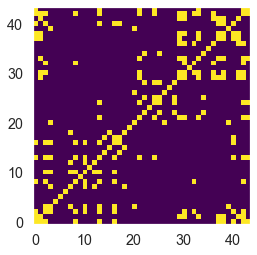

In [29]:
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

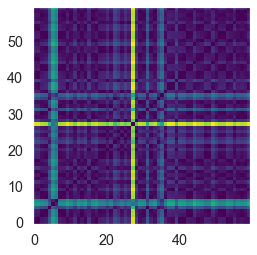

In [31]:
PARAMETROS_RP2 = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP2).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

In [32]:
X_rp

array([[[0.        , 0.00582504, 0.05967903, ..., 0.0553112 ,
         0.03347778, 0.0363903 ],
        [0.00582504, 0.        , 0.06550407, ..., 0.06113625,
         0.03930283, 0.03056526],
        [0.05967903, 0.06550407, 0.        , ..., 0.00436783,
         0.02620125, 0.09606934],
        ...,
        [0.0553112 , 0.06113625, 0.00436783, ..., 0.        ,
         0.02183342, 0.09170151],
        [0.03347778, 0.03930283, 0.02620125, ..., 0.02183342,
         0.        , 0.06986809],
        [0.0363903 , 0.03056526, 0.09606934, ..., 0.09170151,
         0.06986809, 0.        ]],

       [[0.        , 0.05205345, 0.01862383, ..., 0.4054451 ,
         0.41977167, 0.39064074],
        [0.05205345, 0.        , 0.03342962, ..., 0.45749855,
         0.47182512, 0.44269419],
        [0.01862383, 0.03342962, 0.        , ..., 0.42406893,
         0.4383955 , 0.40926456],
        ...,
        [0.4054451 , 0.45749855, 0.42406893, ..., 0.        ,
         0.01432657, 0.01480436],
        [0.4

In [39]:
X_rp[0,:].min()

0.0